Hello

In [87]:

import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import copy
import cv2
from queue import PriorityQueue
from typing import List, Tuple, Dict, Set, Final, Hashable
import importlib
from loguru import logger

In [88]:
def arr(*l):
    return np.array(l)


INF = int(1e9)

class CacRegion:
    def __init__(self, ccw, color):
        self.ccw_pts_id = ccw
        self.color = color

In [89]:
"""
测试时进需要修改本单元格的数据
"""

# [可视化图像宽高]
GLB_H = 150
GLB_W = 150
GLOBAL_MAT = np.zeros((GLB_H + 1, GLB_W + 1), dtype=int)

# [数字颜色对应关系]
CMAP = {-1: "black", 0: "grey", 1: "blue", 2: "yellow", 3: "red", 4: "cyan"}

# [定义所有顶点]

SEG_PTS = [
[13800, 150],
[14100, 150],
[17550, 150],
[21000, 150],
[25700, 150],
[27450, 150],
[27450, 5750],
[25700, 5750],
[25700, 9350],
[21000, 9350],
[17550, 9350],
[17550, 10150],
[14850, 10150],
[14850, 12550],
[13500, 12550],
[13500, 10150],
[13500, 6900],
[13800, 6900],
[13800, 5750], # 18
[13800, 1150], # 19
[17550, 5750],
[21000, 5750],
[14100, 1150], # 22
]

SEG_PTS = [arr(x[0]/100 - 130, x[1]/100) for x in SEG_PTS]

# [逆时针]
WALL_PT_PATH = list(range(20))

# 指定前几个作为房间边缘，剩下点是不在边缘上的点
CAC_REGIONS_FAKE = [
    ([0, 1, 22, 19], 0),
    ([1, 2, 20, 18, 19, 22], 1),
    ([18, 20, 10, 11, 12, 15, 16, 17], 1),
    ([12, 13, 14, 15], 1), ([2, 3, 21, 20], 2),
    ([20, 21, 9, 10], 2),
    ([3, 4, 7, 21], 3),
    ([21, 7, 8, 9], 3),
    ([4, 5, 6, 7], 4)]
# 指定各个区域的边界点（所有区域无交，最好将房间全覆盖）
# 方式：CacRegion([点1, 点2, ..., 点n], 颜色)
# for i in range(len(CAC_REGIONS_FAKE)):
#     CAC_REGIONS_FAKE[i] = (list(map(lambda x: x + 1 if x != 0 else x, CAC_REGIONS_FAKE[i][0])), CAC_REGIONS_FAKE[i][1])

# print(CAC_REGIONS_FAKE)

CAC_REGIONS_FAKE = [CacRegion(x[0][::1], x[1]) for x in CAC_REGIONS_FAKE]


# 分水器所在区域编号
DESTINATION_PT = 0

SUGGESTED_M0_PIPE_INTERVAL = 2.5

In [90]:
# [new]
import plane
importlib.reload(plane)
from plane import is_counter_clockwise
# assert 每个区域是 ccw 给出的
for cac in CAC_REGIONS_FAKE:
    assert is_counter_clockwise([SEG_PTS[x] for x in cac.ccw_pts_id]), cac.ccw_pts_id

assert all(isinstance(x, np.ndarray) for x in SEG_PTS)

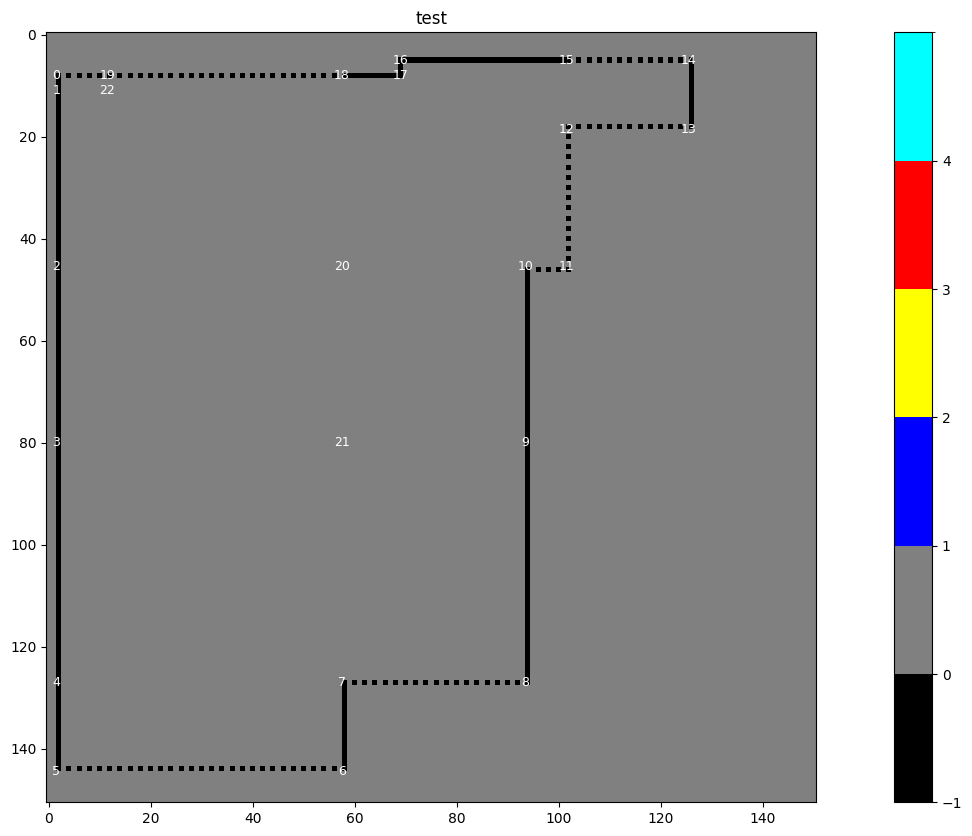

In [91]:
G0_PIPE_WIDTH = SUGGESTED_M0_PIPE_INTERVAL * 2.0

def seg_pts(pts: list, close=False):
    z = zip(pts, pts[1:] + [pts[0]]) if close else zip(pts[:-1], pts[1:])
    blacks = []
    lx, ly = -1, -1
    for pt, nt in z:
        cnt = int(np.ceil(max(abs(pt[0] - nt[0]), abs(pt[1] - nt[1]))))
        for i in range(cnt + 1):
            x = int(np.round(pt[0] + (nt[0] - pt[0]) * i / cnt))
            y = int(np.round(pt[1] + (nt[1] - pt[1]) * i / cnt))
            if (x, y) != (lx, ly):
                lx, ly = x, y
                blacks.append((x, y))
    return blacks


BLACKS = seg_pts([SEG_PTS[i] for i in WALL_PT_PATH], close=True)
for x, y in BLACKS:
    GLOBAL_MAT[x, y] = -1


def plot_matrix(matrix, title=None):
    cmap_list = [CMAP[key] for key in sorted(CMAP.keys())]
    custom_cmap = mcolors.ListedColormap(cmap_list)
    bounds = list(CMAP.keys()) + [max(CMAP.keys()) + 1]
    norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)
    if title is not None:
        plt.title(title)
    plt.imshow(matrix, cmap=custom_cmap, norm=norm)
    plt.colorbar(ticks=sorted(CMAP.keys()))


def plot_num(nums):
    for idx, (x, y) in enumerate(nums):
        plt.text(y, x, str(idx), color='white', fontsize=9, ha='center', va='center')   

plt.figure(figsize=(20, 10))  # 设置图像大小为 12x7
plot_matrix(GLOBAL_MAT, title='test')
plot_num(SEG_PTS)
plt.show()

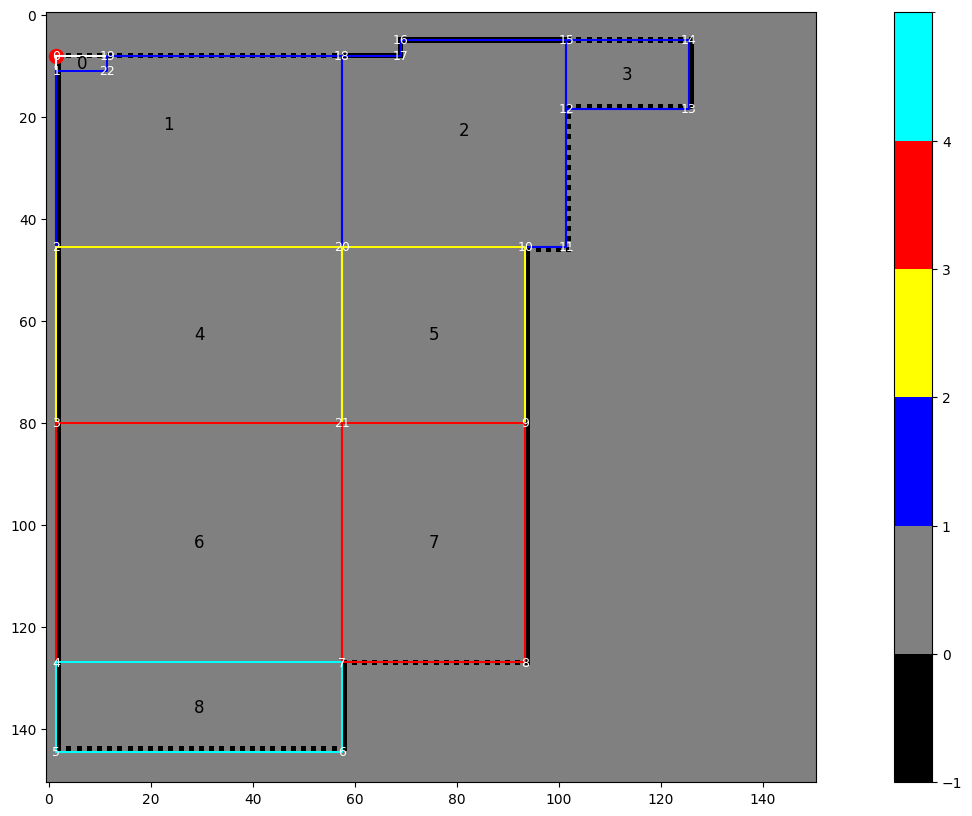

In [92]:
def plot_regions_with_colors(matrix, regions, seg, cmap, dest_pt):
    cmap_list = [cmap[key] for key in sorted(cmap.keys())]
    custom_cmap = mcolors.ListedColormap(cmap_list)
    bounds = list(cmap.keys()) + [max(cmap.keys()) + 1]
    norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)
    
    plt.imshow(matrix, cmap=custom_cmap, norm=norm)
    for idx, region in enumerate(regions):
        x, y = zip(*[seg[i] for i in region.ccw_pts_id])
        x = list(x) + [x[0]]  # 首尾相连
        y = list(y) + [y[0]]  # 首尾相连
        plt.plot(y, x, color=CMAP[region.color] if region.color > 0 else 'white')  # 绘制多边形边缘，颜色为白色
        
        # 计算质心
        centroid_x = sum(x[:-1]) / len(x[:-1])
        centroid_y = sum(y[:-1]) / len(y[:-1])
        plt.text(centroid_y, centroid_x, str(idx), color='black', fontsize=12, ha='center', va='center')  # 显示编号
    # 显示 destination
    plt.colorbar(ticks=sorted(CMAP.keys()))
    plt.scatter([seg[dest_pt][1]], [seg[dest_pt][0]], s=[100], color='red')

plt.figure(figsize=(20, 10))  # 设置图像大小为 20x10
plot_regions_with_colors(GLOBAL_MAT, CAC_REGIONS_FAKE, SEG_PTS, CMAP, DESTINATION_PT)
plot_num(SEG_PTS)
plt.show()


In [93]:
# smaller pt_id, larger pt_id
EdgeId = Tuple[int, int]

def edge_id(tu: Tuple[int, int]) -> EdgeId:
    return min(tu), max(tu)

class EdgePipes:
    def __init__(self, pipes=None):
        self.ccw_pipes = pipes if pipes is not None else list()
    
    def insert_pipe(self, x_lt_y, idx, pipe_seg_id):
        self.ccw_pipes.insert(idx if x_lt_y else len(self.ccw_pipes) - idx, pipe_seg_id)
    def get_pipes(self, x_lt_y):
        return self.ccw_pipes if x_lt_y else list(reversed(self.ccw_pipes))

In [94]:
# dijkstra 求各个 Region 反向 dijkstra 顺序
PT_EDGE_TO = [[] for _ in range(len(SEG_PTS))]
for r in CAC_REGIONS_FAKE:
    for x, y in zip(r.ccw_pts_id, r.ccw_pts_id[1:] + [r.ccw_pts_id[0]]):
        PT_EDGE_TO[x].append(y)
        PT_EDGE_TO[y].append(x)
# 每个点的出点按极角排序 -pi ~ pi
for id in range(len(SEG_PTS)):
    # 去重
    PT_EDGE_TO[id] = list(set(PT_EDGE_TO[id]))
    PT_EDGE_TO[id] = sorted(PT_EDGE_TO[id], key=lambda x: np.arctan2(SEG_PTS[x][1] - SEG_PTS[id][1], SEG_PTS[x][0] - SEG_PTS[id][0]))

def pt_dis(pt1, pt2):
    return np.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)

def dijk1(set_pts, dest_pt, pt_to):
    dis = np.ones(len(set_pts), dtype=float) * INF
    q = PriorityQueue()
    q.put((0, dest_pt))
    dis[dest_pt] = 0
    while not q.empty():
        _, pt = q.get()
        for y in pt_to[pt]:
            if dis[y] > dis[pt] + pt_dis(set_pts[pt], set_pts[y]):
                dis[y] = dis[pt] + pt_dis(set_pts[pt], set_pts[y])
                q.put((dis[y], y))
    return dis

PTS_DIS = dijk1(SEG_PTS, DESTINATION_PT, PT_EDGE_TO)

CAC_REGIONS_DIS = [min([PTS_DIS[x] for x in r.ccw_pts_id]) for r in CAC_REGIONS_FAKE]
# print PT_EDGE_TO
print("PT_EDGE_TO:")
for idx, pt in enumerate(SEG_PTS):
    print(idx, PT_EDGE_TO[idx])

PT_EDGE_TO:
0 [1, 19]
1 [2, 22, 0]
2 [3, 20, 1]
3 [4, 21, 2]
4 [5, 7, 3]
5 [6, 4]
6 [5, 7]
7 [4, 6, 8, 21]
8 [7, 9]
9 [21, 8, 10]
10 [20, 9, 11]
11 [10, 12]
12 [11, 13, 15]
13 [12, 14]
14 [15, 13]
15 [16, 12, 14]
16 [17, 15]
17 [18, 16]
18 [19, 20, 17]
19 [0, 22, 18]
20 [2, 21, 10, 18]
21 [3, 7, 9, 20]
22 [1, 19]


In [95]:
class DisjointSet:
    def __init__(self):
        self.fa_di = dict()
        ...

    def add(self, *xs):
        for x in xs:
            if x not in self.fa_di:
                self.fa_di[x] = x

    def find(self, x):
        if self.fa_di[x] != x:
            self.fa_di[x] = self.find(self.fa_di[x])
        return self.fa_di[x]

    def mix(self, x, y):
        self.fa_di[self.find(x)] = self.find(y)

    def get_sets_di(self) -> Dict[int, List[int]]:
        """
        anc -> its set
        """
        di = {}
        for x in self.fa_di:
            fx = self.find(x)
            if fx not in di:
                di[fx] = []
            di[fx].append(x)
        return di

    def get_ancestor_di(self):
        return { x: self.find(x) for x in self.fa_di }

# test
def test_disjoint_set():
    ds = DisjointSet()
    ds.add(1)
    ds.add(2)
    assert(ds.find(1) == 1)
    ds.mix(1, 2)
    assert(ds.find(1) == 2)

    print(ds.get_sets_di())

    ds.add(3)
    ds.add(4)
    print(ds.get_sets_di())
    ds.add(5)
    ds.mix(3, 4)
    print(ds.get_sets_di())
    assert(ds.find(3) == 4)
    ds.mix(1, 4)
    assert(ds.find(1) == 4)
    assert(ds.find(2) == 4)
    assert(ds.find(3) == 4)
    assert(ds.find(5) == 5)
    assert(ds.get_sets_di() == {4: [1, 2, 3, 4], 5: [5]})
    print(ds.get_ancestor_di())
        
test_disjoint_set()

{2: [1, 2]}
{2: [1, 2], 3: [3], 4: [4]}
{2: [1, 2], 4: [3, 4], 5: [5]}
{1: 4, 2: 4, 3: 4, 4: 4, 5: 5}


2025-01-16 21:56:04.307 | INFO     | __main__:dijk2:358 - region 1 will find a path to destination
2025-01-16 21:56:04.309 | WARNING  | __main__:dijk2:384 - path found for region [(1, 2, 0), (1, 0, 0), (0, 1, 0)]
2025-01-16 21:56:04.313 | INFO     | __main__:dijk2:358 - region 4 will find a path to destination
2025-01-16 21:56:04.315 | WARNING  | __main__:dijk2:384 - path found for region [(2, 3, 0), (2, 1, 0), (1, 2, 0), (1, 0, 0), (0, 1, 0)]
2025-01-16 21:56:04.317 | INFO     | __main__:dijk2:358 - region 2 will find a path to destination
2025-01-16 21:56:04.319 | WARNING  | __main__:dijk2:384 - path found for region [(18, 17, 0), (18, 19, 0)]
2025-01-16 21:56:04.323 | INFO     | __main__:dijk2:358 - region 6 will find a path to destination
2025-01-16 21:56:04.324 | WARNING  | __main__:dijk2:384 - path found for region [(3, 4, 0), (3, 2, 0), (2, 3, 0), (2, 1, 0), (1, 2, 0), (1, 0, 0), (0, 1, 0)]
2025-01-16 21:56:04.328 | INFO     | __main__:dijk2:358 - region 5 will find a path to de

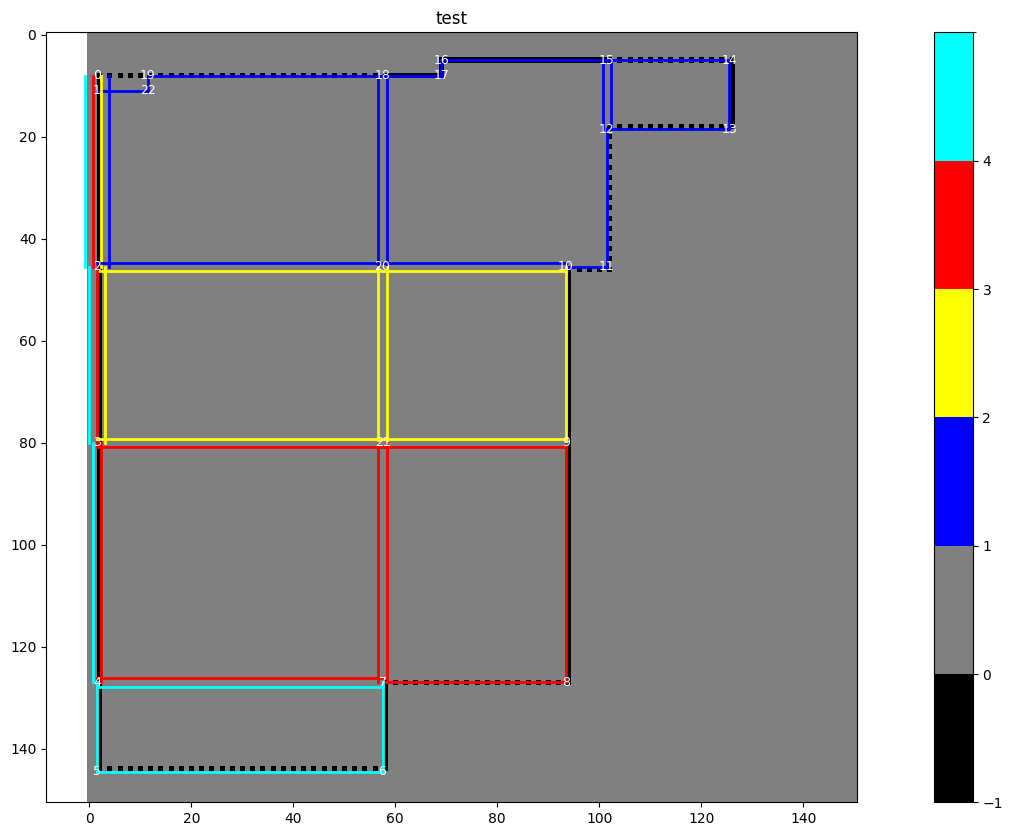

In [106]:
importlib.reload(plane)
from plane import strictly_less
# [NOTE] 之后可以直接搞为管道 id 的 L 位置
# 所在点，所在边的另一个点，是边上正方向第几个管道的 L 位置
StateT = Tuple[int, int, int]
TransferT = Dict[StateT, List[Tuple[StateT, float]]]


def get_djk_states_for_color_at_pt(
    pt_to, color, pt, edge_pipes: Dict[Tuple[int, int], EdgePipes], pipe_color
) -> List[StateT]:
    """
    保证逆时针给出
    """
    # from -pi to pi
    # i 的意义：
    # 若 i 为同色: i 直接对应管道在 EdgePipes 上的编号（存这个编号是为了方便插入）
    # 异色或边缘: i 对应 i 和 i - 1 之间的管道，将新成为 i
    states = []
    for y in pt_to[pt]:
        # pt -> y 方向的逆时针
        eid = edge_id((pt, y))
        ccw_pipes = edge_pipes[eid].ccw_pipes
        # 允许情况: i 颜色相同, 或位于 0 号位置, 或 i - 1 为异色, 若最右边则 i - 1 必须为异色
        i2 = []
        for i in list(range(len(edge_pipes[eid].ccw_pipes) + 1)):
            if i == 0:
                i2.append(i)
                continue
            if i == len(ccw_pipes):
                if pipe_color[ccw_pipes[i - 1]] != color:
                    i2.append(i)
                continue
            if (
                pipe_color[ccw_pipes[i]] == color
                or pipe_color[ccw_pipes[i - 1]] != color
            ):
                i2.append(i)
        if pt > y:
            i2 = list(reversed(i2))
        for i in i2:
            states.append((pt, y, i))
    return states


def test_get_djk_states_for_color_at_pt():
    # 随便构建一张图
    pt_to = [[1], [3, 0, 2, 4], [1], [1], [1]]
    edge_pipes = {
        (0, 1): EdgePipes([8, 7]),
        (1, 2): EdgePipes([1, 2, 3, 0]),
        (1, 3): EdgePipes([6, 4, 5]),
        (1, 4): EdgePipes(),
    }
    pipe_color = [6, 7, 6, 1, 7, 6, 6, 7, 1]
    states = get_djk_states_for_color_at_pt(pt_to, 1, 1, edge_pipes, pipe_color)
    states = get_djk_states_for_color_at_pt(pt_to, 1, 2, edge_pipes, pipe_color)
    assert tuple(states) == tuple([(2, 1, 4), (2, 1, 2), (2, 1, 1), (2, 1, 0)])
    # 输出 [(2, 1, 4)]? 表示一个在 2 点上，指向 1 的边上，在 (1, 2) 边的第 4 个管道L位置上


test_get_djk_states_for_color_at_pt()


def test_get_djk_states_for_color_at_pt2():
    # 随便构建一张图
    pt_to = [[1], [3, 0, 2, 4], [1], [1], [1]]
    edge_pipes = {
        (0, 1): EdgePipes([8, 7]),
        (1, 2): EdgePipes([1, 2, 3, 0]),
        (1, 3): EdgePipes([6, 4, 5]),
        (1, 4): EdgePipes(),
    }
    pipe_color = [6, 7, 6, 1, 7, 6, 6, 7, 1]
    state_set = set()
    for pt in range(5):
        states = get_djk_states_for_color_at_pt(pt_to, 1, pt, edge_pipes, pipe_color)
        for state in states:
            state_set.add(state)
    for st in state_set:
        pt, y, i = st
        assert (y, pt, i) in state_set


test_get_djk_states_for_color_at_pt2()


def get_djk_transfer_for_color(
    pt_to, region_color, edge_pipes, pipe_color, seg_pts, pt_pipe_sets, w_sug
):
    transfer: TransferT = dict()
    # List as Dict
    ccw_djk_states_of_pt = [
        get_djk_states_for_color_at_pt(pt_to, region_color, pt, edge_pipes, pipe_color)
        for pt in range(len(seg_pts))
    ]
    # print(f'{edge_pipes[(2, 3)].ccw_pipes}, {edge_pipes[(4, 5)].ccw_pipes}')
    for pt in range(len(seg_pts)):
        djk_states: List[StateT] = ccw_djk_states_of_pt[pt]
        for s in djk_states:
            transfer[s] = []
            inv = (s[1], s[0], s[2])
            # check color
            ccw_pipe_li = edge_pipes[edge_id((s[0], s[1]))].ccw_pipes
            # 同色管道存在，则转移到对面的代价为 0.
            # 注意，同色管道存在，但可能尚未连接到 destination
            if (
                s[2] < len(ccw_pipe_li)
                and region_color == pipe_color[ccw_pipe_li[s[2]]]
            ):
                transfer[s].append((inv, 0))
            else:
                transfer[s].append((inv, pt_dis(seg_pts[s[0]], seg_pts[s[1]])))

        """
        下面判断一个点内部的状态转移，需要逆时针遍历管道并根据各并查集经过次数的元组来判断是否可连过去
        例：
            - 某一个 state: 并查集 1 经过次数 0，并查集 2 经过次数 2
            - 另一个 state: 并查集 1 经过次数 0，并查集 2 经过次数 2
            - 则他们可以转移
        """

        # 遍历任何一个状态为 [[set1_id(祖先), set1_cnt], [set2_id, set2_cnt], ...]
        # 更新 cnt 方式: 根据 edge pipe idx 找到对应的 pipe id

        pipe_sets_di = pt_pipe_sets[pt].get_sets_di()
        ancestor_di = pt_pipe_sets[pt].get_ancestor_di()
        # 记录祖先对应集合的元素的出现次数
        cnt_di = {x: 0 for x in pipe_sets_di.keys() if pipe_color[x] != region_color}

        def key(di):
            """
            传入 cnt_di，转换为键（忽略同色键值对, 即若 pipe_color[k] == color 不计入 key tuple）
            """
            nonlocal region_color, pipe_color
            # return tuple(sorted(di.items()))
            return tuple(
                sorted([x for x in di.items() if pipe_color[x[0]] != region_color])
            )

        def go_through(x, y, st, ed):
            """
            &mut: cnt_di
            &ancestor_di
            &cnt_state_sets
            &edge_pipes
            &region_color
            &pipe_color

            方案 10L -> 方案 8L ，路过了 9, 8
            方案 0L -> 方案 2L: 路了 0, 1
            接同色 / 生长本颜色
            """
            eid = edge_id((x, y))
            pipes = edge_pipes[eid].ccw_pipes
            st, ed = np.clip(st, 0, len(pipes)), np.clip(ed, 0, len(pipes))

            def ccw_cross_i(i):
                pipe_id = pipes[i]
                if pipe_color[pipe_id] == region_color:
                    return
                sz = len(pipe_sets_di[ancestor_di[pipe_id]])
                cnt_di[ancestor_di[pipe_id]] += 1
                cnt_di[ancestor_di[pipe_id]] %= sz

            # [NOTE] 这里其实不用判断方向
            if st < ed:
                for i in range(st, ed):
                    # 越过 i 号现存管道，统计 cnt 变化
                    ccw_cross_i(i)
            else:
                for i in range(st - 1, ed - 1, -1):
                    ccw_cross_i(i)

        ls = djk_states[0]
        cnt_state_sets: Dict[Tuple, Set[StateT]] = {key(cnt_di): {ls}}
        for s in djk_states[1:]:
            # 更新 cnt_di
            if s[1] == ls[1]:
                # 内部判断走向
                go_through(ls[0], ls[1], ls[2], s[2])
            else:
                # 不是同一个边内的，这里得判断走向
                if ls[0] < ls[1]:
                    go_through(ls[0], ls[1], ls[2], +INF)
                else:
                    go_through(ls[0], ls[1], ls[2], -INF)
                if s[0] < s[1]:
                    go_through(s[0], s[1], -INF, s[2])
                else:
                    go_through(s[0], s[1], +INF, s[2])
            k = key(cnt_di)
            if k not in cnt_state_sets:
                cnt_state_sets[k] = set()
            cnt_state_sets[k].add(s)
            ls = s  # 不用 copy

        # 走了一圈，各并查集路过次数必须都归 0
        assert np.all([v == 0 for v in cnt_di.values()])
        # 一个 key 的所有状态可以互相到达
        for _, v in cnt_state_sets.items():
            for s in v:
                for ss in v:
                    if s != ss:
                        # 此处默认同点上转移代价为 w_sug，
                        # 如果设置为 0 可能多次转移
                        transfer[s].append((ss, w_sug))
    return ccw_djk_states_of_pt, transfer


def test_transfer():
    pt_to = [[1], [3, 0, 2, 4], [1], [1], [1]]
    edge_pipes = {
        (0, 1): EdgePipes([8, 7]),
        (1, 2): EdgePipes([0, 1, 2, 3]),
        (1, 3): EdgePipes([6, 4, 5]),
        (1, 4): EdgePipes(),
    }
    pipe_color = [1, 7, 6, 6, 6, 7, 6, 7, 1]
    seg_pts = [(3, 0), (1, 1), (2, 4), (-1, -1), (0, 4)]
    pt_pipe_sets = {x: DisjointSet() for x in range(len(seg_pts))}
    pt_pipe_sets[0].add(7, 8)

    pt_pipe_sets[1].add(*range(9))
    pt_pipe_sets[1].mix(3, 6)
    pt_pipe_sets[1].mix(2, 4)
    pt_pipe_sets[1].mix(1, 5)
    pt_pipe_sets[1].mix(1, 7)
    pt_pipe_sets[1].mix(0, 8)

    pt_pipe_sets[2].add(0, 1, 2, 3)
    pt_pipe_sets[3].add(4, 5, 6)

    _, transfer = get_djk_transfer_for_color(
        pt_to, 7, edge_pipes, pipe_color, seg_pts, pt_pipe_sets
    )


# test_transfer()


# color 不为零的进行考虑边上 pipes 的反向 Dijkstra
def dijk2(seg_pts, pt_to, cac_regions, destination_pt, cac_regions_dis, w_sug):
    """
    order:
    - 原点相关
    - 边
    - 仙人掌图相关

    [约定]
    - 每条边的正方向：小点 -> 大点
    - 新状态位置: 0 (0) 1 (1) 2

    - 终点为根区域边
    - 同色边代价为 0. (dijkstra 为新增边最短)
    - 如何表示 djk 状态？
        - 点，边，管道
        - 同色：直接对应 i 管道
        - 连续两个异色 / 边缘异色：挤到原 i （右边） 和 i - 1 之间
    - 初始化 edge_state. edge_state 用 CacEdge 完全表示
        - 区域边缘加管道（逆时针遍历自己，插左边）
    - 每个区域寻路：建新图
        - state
            - pt, y, pipenum
            - (edge_state, color) -> state?
                 - pipe: get_pipes
                 - x, y, i (and y, x, i)
        - transfer
    """
    djk_order = np.argsort(cac_regions_dis)
    edge_pipes: Dict[Tuple[int, int], EdgePipes] = dict()
    for r in cac_regions:
        for x, y in zip(r.ccw_pts_id, r.ccw_pts_id[1:] + [r.ccw_pts_id[0]]):
            if edge_id((x, y)) not in edge_pipes:
                edge_pipes[edge_id((x, y))] = EdgePipes()

    # 每个 Disjoint Set 存储管道线段的 id 的集合
    pt_pipe_sets: Dict[int, DisjointSet] = {
        x: DisjointSet() for x in range(len(seg_pts))
    }
    pipe_color = (
        list()
    )  # start from 0，.[i] 存储第 i 个管道的颜色. pipe 实际上是 pipe 线段.
    region_start_pipes = [[] for _ in range(len(cac_regions))]
    # 每个有色区域逆时针一周添加管道。相邻的添加的管道在一个 pt_pipe_seg 中
    for i, r in enumerate(cac_regions):
        if r.color == 0:
            continue
        pipes_added = []
        for x, y in zip(r.ccw_pts_id, r.ccw_pts_id[1:] + [r.ccw_pts_id[0]]):
            """
            x -> y 加一条边
            """
            pipe_color.append(r.color)
            pipe_id = len(pipe_color) - 1
            pipes_added.append(pipe_id)
            # ex: 2 -> 3, [2 <- 1 <- 0] 从右往左存，插入到左边最后一个位置
            edge_pipes[edge_id((x, y))].insert_pipe(x > y, 0, pipe_id)
            region_start_pipes[i].append(pipe_id)

        for x, pre_pipe, nxt_pipe in zip(
            r.ccw_pts_id, pipes_added[-1:] + pipes_added[:-1], pipes_added
        ):
            pt_pipe_sets[x].add(pre_pipe)
            pt_pipe_sets[x].add(nxt_pipe)
            pt_pipe_sets[x].mix(pre_pipe, nxt_pipe)

    def state_attach_region(s, region_id):
        pipes = edge_pipes[edge_id((s[0], s[1]))].ccw_pipes
        return s[2] < len(pipes) and pipes[s[2]] in region_start_pipes[region_id]

    # 存储每个颜色已经连到 destination 的状态
    colors_finished_states: Dict[int, Set[StateT]] = dict()
    for region_ord in djk_order:
        # print(f"--- {region_ord} ---")
        region_color = cac_regions[region_ord].color
        if region_color == 0:
            continue
        djk_states_pt, transfer = get_djk_transfer_for_color(
            pt_to, region_color, edge_pipes, pipe_color, seg_pts, pt_pipe_sets, w_sug
        )
        dis = {}
        # Father state
        fa_s: Dict[StateT, StateT] = dict()
        for pt in range(len(seg_pts)):
            for s in djk_states_pt[pt]:
                dis[s] = INF
                fa_s[s] = (-1, -1, -1)

        def state_is_finished(s):
            if region_color not in colors_finished_states:
                return s[0] == destination_pt
            return s in colors_finished_states[region_color]

        def state_is_illegal(s):
            # 本颜色已经有区域连到终点了，则不许再搜到终点
            return region_color in colors_finished_states and s[0] == destination_pt

        q = PriorityQueue()
        this_region_is_finished = False

        region_start_states = []
        for pt in range(len(seg_pts)):
            for s in djk_states_pt[pt]:
                if state_attach_region(s, region_ord):
                    if state_is_finished(s):
                        this_region_is_finished = True
                    if not state_is_illegal(s):
                        region_start_states.append(s)
                        q.put((0, s))
                        dis[s] = 0

        if this_region_is_finished:
            for s in region_start_states:
                colors_finished_states.setdefault(region_color, set()).add(s)
            logger.info(f"region {region_ord} already connected to destination")
            continue
        logger.info(f"region {region_ord} will find a path to destination")

        while not q.empty():
            _, s = q.get()
            # 终点不用继续搜
            if state_is_finished(s):
                continue
            for t, d in transfer[s]:
                if not state_is_illegal(t) and strictly_less(dis[s] + d, dis[t]):
                    dis[t] = dis[s] + d
                    fa_s[t] = s
                    q.put((dis[t], t))
        found_finished_states_and_dis = []
        for k, v in dis.items():
            if state_is_finished(k):
                found_finished_states_and_dis.append((k, v))
        back_s = found_finished_states_and_dis[
            np.argmin([v for k, v in found_finished_states_and_dis])
        ][0]
        assert dis[back_s] < INF  # 有解
        s_chain: List[StateT] = [back_s]
        while not state_attach_region(back_s, region_ord):
            back_s = fa_s[back_s]
            s_chain.append(back_s)
        s_chain.reverse()

        logger.warning(f"path found for region {s_chain}")

        for s in s_chain:
            colors_finished_states.setdefault(region_color, set()).add(s)
        for s in region_start_states:
            colors_finished_states.setdefault(region_color, set()).add(s)

        # [v2] 可能一条边上绕了远路加多个管道
        # - Tuple[int, int] 为要加的 idx 和 pipe_id
        # - 由于 dijkstra 的广搜性质，不会走 pt 上非必要的点
        pipe_indices_to_add_on_edge: Dict[EdgeId, List[Tuple[int, int]]] = dict()
        pipe_id_of_chain_states: Dict[StateT, int] = dict()
        for s, ns in zip(s_chain[:-1], s_chain[1:]):
            """
            如何优雅获得每个状态对应 pipe?
            - 反转边
                - 可能是一个新增的 pipe
            - 同点边
            """
            if (s[0], s[1]) == (ns[1], ns[0]):
                eid = edge_id((s[0], s[1]))
                pipes = edge_pipes[eid].ccw_pipes
                
                idx_is_same_color = (
                    s[2] < len(pipes) and pipe_color[pipes[s[2]]] == region_color
                ) # 意味着其实是经过存在的一条边而不是加边
                if idx_is_same_color:
                    pipe_id_of_chain_states[s] = pipes[s[2]]
                    pipe_id_of_chain_states[ns] = pipes[s[2]]
                    continue
                pipe_color.append(region_color)
                pipe_id = len(pipe_color) - 1

                pipe_id_of_chain_states[s] = pipe_id
                pipe_id_of_chain_states[ns] = pipe_id

                pt_pipe_sets[s[0]].add(pipe_id)
                pt_pipe_sets[s[1]].add(pipe_id)
                pipe_indices_to_add_on_edge.setdefault(eid, []).append((s[2], pipe_id))
        for s in s_chain:
            if s not in pipe_id_of_chain_states:
                # assert edge_id((s[0], s[1])) in pipe_indices_to_add_on_edge
                pipe_id_of_chain_states[s] = edge_pipes[edge_id((s[0], s[1]))].ccw_pipes[s[2]]

        for eid, idx_pipes in pipe_indices_to_add_on_edge.items():
            cnt = 0
            for idx, pipe_id in sorted(idx_pipes, key=lambda x: x[0]):
                edge_pipes[eid].insert_pipe(True, idx + cnt, pipe_id)
                cnt += 1 # 后续插入的管道会往后挤
            
        for s, ns in zip(s_chain[:-1], s_chain[1:]):
            # mix them
            if s[0] == ns[0]:
                pt_pipe_sets[s[0]].mix(pipe_id_of_chain_states[s], pipe_id_of_chain_states[ns])
                
        """
        # [v1]
        pipe_path_at_pt = {x: set() for x in range(len(seg_pts))}
        # 起始边加入 path set
        pipe_path_at_pt[s_chain[0][0]].add(
            edge_pipes[edge_id((s_chain[0][0], s_chain[0][1]))].ccw_pipes[s_chain[0][2]]
        )
        for s, ns in zip(s_chain[:-1], s_chain[1:]):
            if (s[0], s[1]) == (ns[1], ns[0]):
                # 以下部分假设走了一条边
                eid = edge_id((s[0], s[1]))
                pipes = edge_pipes[eid].ccw_pipes
                in_fact_same_color = (
                    s[2] < len(pipes) and pipe_color[pipes[s[2]]] == region_color
                )
                # 可能以不同色多次经过一条边
                if not in_fact_same_color:
                    pipe_color.append(region_color)
                    pipe_id = len(pipe_color) - 1
                    edge_pipes[eid].insert_pipe(True, s[2], pipe_id)
                    pt_pipe_sets[s[0]].add(pipe_id)
                    pt_pipe_sets[s[1]].add(pipe_id)

                    pipe_path_at_pt[s[0]].add(pipe_id)
                    pipe_path_at_pt[s[1]].add(pipe_id)
                    # print(
                    #     f"insert {s[0]} -> {s[1]} at {s[2]}, color {region_color} pipe_id {pipe_id}"
                    # )
                else:
                    pipe_id = pipes[s[2]]
                    pipe_path_at_pt[s[0]].add(pipe_id)
                    pipe_path_at_pt[s[1]].add(pipe_id)

        for pt in range(len(seg_pts)):
            pipes = pipe_path_at_pt[pt]
            if len(pipes) >= 2:
                assert len(pipes) == 2
                pt_pipe_sets[pt].mix(*pipes)
        """

    # [test]
    def test_plot_transfer():
        def plot_transfer(transfer, seg_pts):
            for s, li in transfer.items():
                for t in li:
                    st = s[0]
                    ed = t[0][0]
                    d = t[1]
                    if st == ed:
                        continue
                    start_pt = seg_pts[st]
                    end_pt = seg_pts[ed]
                    plt.arrow(
                        start_pt[1],
                        start_pt[0],
                        end_pt[1] - start_pt[1],
                        end_pt[0] - start_pt[0],
                        head_width=1,
                        head_length=2,
                        fc="red",
                        ec="red",
                    )
                    mid_x = (start_pt[0] + end_pt[0]) / 2
                    mid_y = (start_pt[1] + end_pt[1]) / 2
                    plt.text(
                        mid_y,
                        mid_x,
                        f"{d:.1f}",
                        color="blue",
                        fontsize=8,
                        ha="center",
                        va="center",
                    )

        plt.figure(figsize=(20, 10))
        plot_matrix(GLOBAL_MAT, title="test")
        plot_num(SEG_PTS)
        plot_transfer(transfer, SEG_PTS)
        plt.show()

    def test_plot_pipes():
        def plot_pipes(edge_pipes, seg_pts, pipe_color, cmap):
            for (x, y), edge in edge_pipes.items():
                st, ed = seg_pts[x], seg_pts[y]

                def normalized(v):
                    return v / np.linalg.norm(v)

                dir = normalized(ed - st)
                dir_left = np.array([-dir[1], dir[0]])
                oy, ox = dir_left * 1.6

                sti = -len(edge.ccw_pipes) / 2 + 0.5
                for idx, pipe_id in enumerate(edge.ccw_pipes):
                    color = cmap[pipe_color[pipe_id]]
                    i = idx + sti
                    plt.plot(
                        [st[1] + i * ox, ed[1] + i * ox],
                        [st[0] + i * oy, ed[0] + i * oy],
                        color=color,
                        linewidth=2,
                    )

        plt.figure(figsize=(20, 10))
        plot_matrix(GLOBAL_MAT, title="test")
        plot_num(SEG_PTS)
        plot_pipes(edge_pipes, SEG_PTS, pipe_color, CMAP)
        plt.show()

    test_plot_pipes()
    return edge_pipes, pt_pipe_sets, pipe_color


EDGE_PIPES, PT_PIPE_SETS, PIPE_COLOR = dijk2(
    SEG_PTS, PT_EDGE_TO, CAC_REGIONS_FAKE, DESTINATION_PT, CAC_REGIONS_DIS, G0_PIPE_WIDTH
)

- 点分，边拆
- 每个并查集选一个中心点 (x, y)

------
[ 8.  57.5] [45.5 57.5]
---
5.0
5.0
5.0
5.0
5.0
[45.5 57.5] [45.5 93.5]
---
5.0
5.0
5.0
5.0
5.0
[45.5 93.5] [ 45.5 101.5]
---
5.0
5.0
5.0
5.0
5.0
[ 45.5 101.5] [ 18.5 101.5]
---
5.0
4.0
4.0
4.0
4.0
[ 18.5 101.5] [  5.  101.5]
---
5.0
5.0
5.0
5.0
5.0
[  5.  101.5] [ 5. 69.]
---
5.0
5.0
1.5
1.5
1.5
[ 5. 69.] [ 8. 69.]
---
5.0
5.0
5.0
3.0
3.0
[ 8. 69.] [ 8.  57.5]
---
5.0
5.0
5.0
5.0
5.0


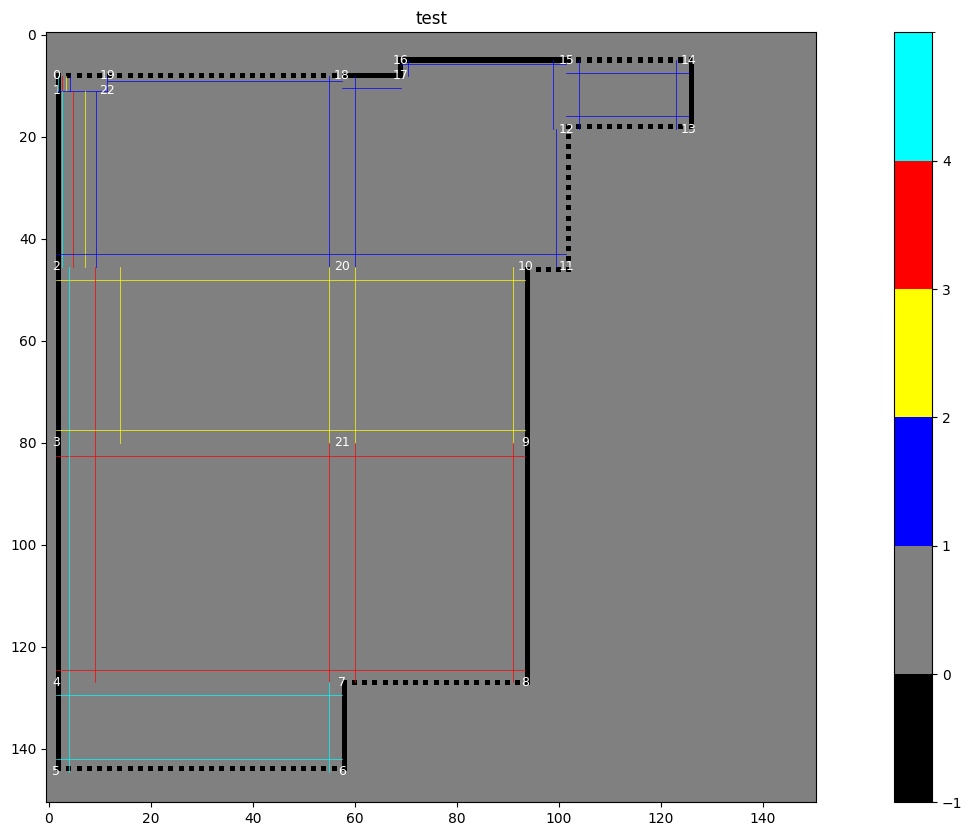

(0, 1): [47, 43, 40, 38]
(1, 22): [5]
(19, 22): [4]
(0, 19): []
(1, 2): [46, 42, 39, 0]
(2, 20): [21, 1]
(18, 20): [2, 6]
(18, 19): [3]
(10, 20): [7, 25]
(10, 11): [8]
(11, 12): [9]
(12, 15): [17, 10]
(15, 16): [11]
(16, 17): [12]
(17, 18): [13]
(12, 13): [14]
(13, 14): [15]
(14, 15): [16]
(2, 3): [45, 41, 18]
(3, 21): [29, 19]
(20, 21): [20, 22]
(9, 21): [23, 33]
(9, 10): [24]
(3, 4): [44, 26]
(4, 7): [37, 27]
(7, 21): [30, 28]
(7, 8): [31]
(8, 9): [32]
(4, 5): [34]
(5, 6): [35]
(6, 7): [36]


In [107]:
# [new]
# def poly_edge_pipe_width_v1(poly: Polygon, edge_pipe_num: List[float], sug_w: float):
# 检查所有 region。如果边为墙边，则 num = len，否则 len / 2
import plane
import importlib

importlib.reload(plane)
from plane import Polygon, Point, poly_edge_pipe_width_v1, PipeOnAxis

"""
@dataclass
class PipeOnAxis:
    id: int
    x: float
    rw: float  # 右边宽度
    lw: float


def pt_edge_pipes_generate_pts_v1(
    center: Point, edge_pipes: List[List[PipeOnAxis]], edge_dir: List[Vec]
) -> Dict[int, Point]:
"""


# 约定是墙必须由连续的开始组成
def edge_is_wall(eid: EdgeId, wall_pt_path):
    assert eid[0] < eid[1]
    for e in zip(wall_pt_path, wall_pt_path[1:] + [wall_pt_path[0]]):
        if edge_id(e) == eid:
            return True
    return False


def get_xw_for_each_pipe(regions, seg_pts, wall_pt_path, edge_pipes, sug_w):
    pipe_xw: Dict[int, PipeOnAxis] = dict()
    for cac in regions:
        for pti, nxt in zip(cac.ccw_pts_id, cac.ccw_pts_id[1:] + [cac.ccw_pts_id[0]]):
            for pipe_id in edge_pipes[edge_id((pti, nxt))].ccw_pipes:
                if pipe_id not in pipe_xw:
                    pipe_xw[pipe_id] = PipeOnAxis(pipe_id, np.nan, np.nan, np.nan)
    # fill this

    for cac in regions:
        pts: Polygon = [seg_pts[i] for i in cac.ccw_pts_id]
        n = len(pts)
        edge_pipe_num = []
        for uid, vid in zip(cac.ccw_pts_id, cac.ccw_pts_id[1:] + [cac.ccw_pts_id[0]]):
            eid = edge_id((uid, vid))
            if edge_is_wall(eid, wall_pt_path):
                edge_pipe_num.append(len(edge_pipes[eid].ccw_pipes))
            else:
                edge_pipe_num.append(len(edge_pipes[eid].ccw_pipes) / 2.0)
        verbose = 16 in cac.ccw_pts_id
        edge_pipe_width = poly_edge_pipe_width_v1(
            pts, edge_pipe_num, sug_w, verbose=verbose
        )

        # 更新所谓 xw
        def dir_range(x, y, dir):
            if x > y:
                return range(0)
            if dir > 0:
                return range(x, y + dir, dir)
            return range(y, x + dir, dir)

        def dir_range2(x, y, mid, dir):
            if x > y:
                return range(0)
            if dir > 0:
                return range(mid, y + dir, dir)
            return range(mid, x + dir, dir)

        for e_idx_in_region, (uid, vid) in enumerate(
            zip(cac.ccw_pts_id, cac.ccw_pts_id[1:] + [cac.ccw_pts_id[0]])
        ):
            eid = edge_id((uid, vid))
            m = len(edge_pipes[eid].ccw_pipes)
            half_w = edge_pipe_width[e_idx_in_region] / 2.0
            x, y, mid, dir = 0, m - 1, (m - 1) / 2, (1 if uid < vid else -1)

            def range_update(r: range, last: float):
                for idx in r:
                    pipe_id = edge_pipes[eid].ccw_pipes[idx]
                    pipe_xw[pipe_id].rw = half_w
                    pipe_xw[pipe_id].lw = half_w
                    pipe_xw[pipe_id].x = last + half_w * dir
                    last = pipe_xw[pipe_id].x + half_w * dir

            if edge_is_wall(eid, wall_pt_path):
                range_update(dir_range(x, y, dir), 0)
            else:
                # 填一半。朝向当前 region 内部的方向
                if m % 2 == 0:
                    range_update(
                        dir_range2(x, y, int(np.round(mid + 0.5 * dir)), dir), 0
                    )
                else:
                    int_mid = int(np.round(mid))
                    if dir == 1:
                        # 朝着 l 方向走的
                        pipe_xw[edge_pipes[eid].ccw_pipes[int_mid]].lw = half_w
                    else:
                        pipe_xw[edge_pipes[eid].ccw_pipes[int_mid]].rw = half_w
                    pipe_xw[edge_pipes[eid].ccw_pipes[int_mid]].x = 0
                    range_update(
                        dir_range2(x, y, int(np.round(mid + dir)), dir), half_w * dir
                    )

    return pipe_xw


PIPE_XW = get_xw_for_each_pipe(
    CAC_REGIONS_FAKE, SEG_PTS, WALL_PT_PATH, EDGE_PIPES, G0_PIPE_WIDTH
)

# [assert no nan]


def test_plot_pipes():
    def plot_pipes(edge_pipes, seg_pts, pipe_color, cmap, pipe_xw):
        for (x, y), edge in edge_pipes.items():
            st, ed = seg_pts[x], seg_pts[y]

            def normalized(v):
                return v / np.linalg.norm(v)

            dir = normalized(ed - st)
            dir_left = np.array([-dir[1], dir[0]])  # x 正方向

            for idx, pipe_id in enumerate(edge.ccw_pipes):
                color = cmap[pipe_color[pipe_id]]
                x = pipe_xw[pipe_id].x
                so_st = st + dir_left * x
                so_ed = ed + dir_left * x
                plt.plot(
                    [so_st[1], so_ed[1]],
                    [so_st[0], so_ed[0]],
                    color=color,
                    linewidth=0.5,
                )

    # [pt sets]
    # print('--- pt sets ---')
    # for k, v in pt_pipe_sets.items():
    #     print(f'{k}:')
    #     print(v.get_sets_di())

    plt.figure(figsize=(20, 10))
    plot_matrix(GLOBAL_MAT, title="test")
    plot_num(SEG_PTS)
    plot_pipes(EDGE_PIPES, SEG_PTS, PIPE_COLOR, CMAP, PIPE_XW)
    plt.show()


# (21, 22) 为一 eid
# 获取其上所有 pipe_id (int)
# PIPE_XW[pipe_id] 存的 x, rw, lw 方向为 eid 方向
# [BUG] 这里宽度为啥 3.16，不到 4.5?
test_plot_pipes()

for K, V in EDGE_PIPES.items():
    print(f"{K}: {V.ccw_pipes}")

for K, V in PIPE_XW.items():
    MES = f"pipe {K} has nan member"
    assert not np.isnan(V.x), MES
    assert not np.isnan(V.rw), MES
    assert not np.isnan(V.lw), MES


20 {1: array([43. , 52.5]), 21: array([48. , 52.5]), 20: array([50.5, 55. ]), 22: array([50.5, 60. ]), 25: array([48. , 62.5]), 7: array([43. , 62.5]), 6: array([40.5, 60. ]), 2: array([40.5, 55. ])}
此处 rw 方向以 uid 为中心向外
[[PipeOnAxis(id=1, x=-2.5, rw=2.5, lw=2.5), PipeOnAxis(id=21, x=2.5, rw=2.5, lw=2.5)], [PipeOnAxis(id=20, x=-2.5, rw=2.5, lw=2.5), PipeOnAxis(id=22, x=2.5, rw=2.5, lw=2.5)], [PipeOnAxis(id=25, x=-2.5, rw=2.5, lw=2.5), PipeOnAxis(id=7, x=2.5, rw=2.5, lw=2.5)], [PipeOnAxis(id=6, x=-2.5, rw=2.5, lw=2.5), PipeOnAxis(id=2, x=2.5, rw=2.5, lw=2.5)]]
[array([ 0., -1.]), array([1., 0.]), array([0., 1.]), array([-1.,  0.])]
21 {19: array([77.5, 52.5]), 29: array([82.5, 52.5]), 28: array([85., 55.]), 30: array([85., 60.]), 33: array([82.5, 62.5]), 23: array([77.5, 62.5]), 22: array([75., 60.]), 20: array([75., 55.])}
此处 rw 方向以 uid 为中心向外
[[PipeOnAxis(id=19, x=-2.5, rw=2.5, lw=2.5), PipeOnAxis(id=29, x=2.5, rw=2.5, lw=2.5)], [PipeOnAxis(id=28, x=-2.5, rw=2.5, lw=2.5), PipeOnAxis(id=

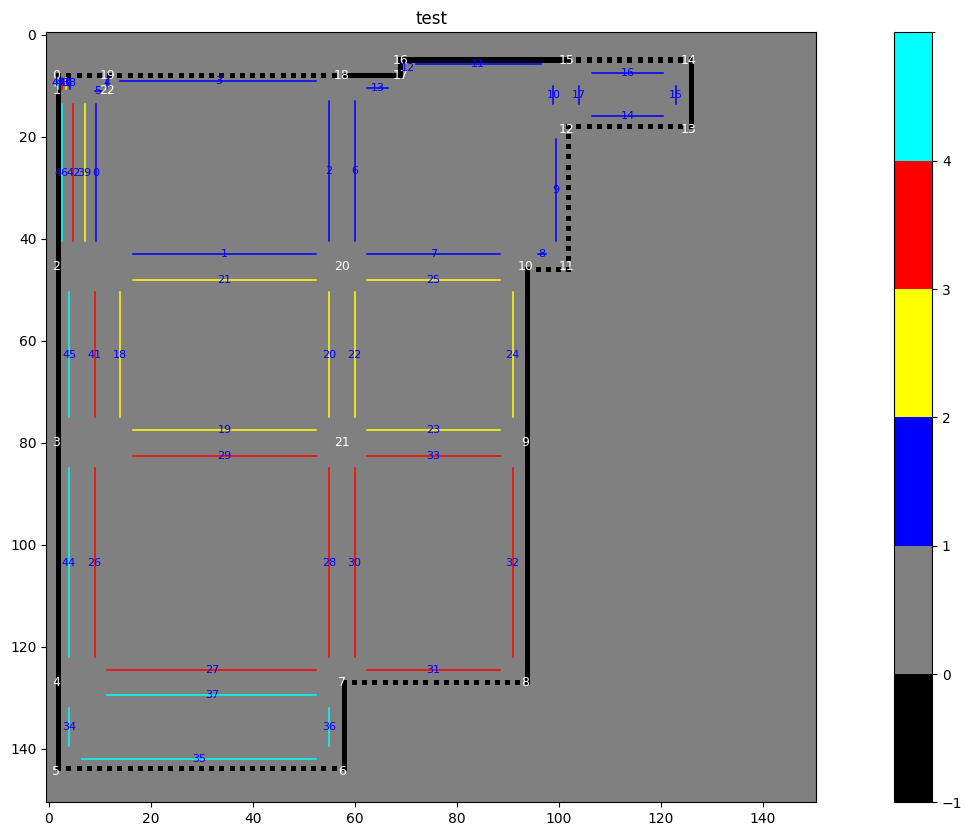

In [98]:
import importlib
import plane
importlib.reload(plane)
from plane import pt_edge_pipes_expand_pts_v1, normalized
from dataclasses import dataclass

"""
def pt_edge_pipes_generate_pts_v1(
    center: Point, edge_pipes: List[List[PipeOnAxis]], edge_dir: List[Vec]
) -> Dict[int, Point]:
"""

# pipe_id, pt_id
G2Node = Tuple[int, int]

G2Edge = Tuple[G2Node, G2Node]


def get_g2_edge_id(e: G2Edge):
    assert e[0] != e[1]
    if e[0] < e[1]:
        return e
    return (e[1], e[0])

@dataclass
class G0EdgeInfo:
    # x -> y, 逆时针(右向左)
    #      y node
    #      ^
    # L<---|----R
    #      | 
    #      x node
    rw: float
    lw: float

    

def get_endpoint_for_each_pipe(seg_pts, pt_edge_to, edge_pipes, pipe_wx):
    # 初步生成
    node_set: Set[G2Node] = set()
    edge_dict: Dict[G2Node, List[G2Node]] = dict()
    node_pos: Dict[G2Node, Point] = dict()
    pipe_pt: Dict[int, List[int]] = dict()
    edge_info_s1: Dict[G2Edge, G0EdgeInfo] = dict()


    for uid in range(len(seg_pts)):
        center = seg_pts[uid]
        edge_dir = []
        u_edge_pipes = []
        for vid in pt_edge_to[uid]:
            eid = edge_id((uid, vid))
            edge_dir.append(normalized(seg_pts[vid] - center))
            # 此 list 的 pipe_id 顺序为 uid -> vid 方向
            pipe_id_li = edge_pipes[eid].get_pipes(uid < vid)
            wx_uv = [copy.deepcopy(pipe_wx[pipe_id]) for pipe_id in pipe_id_li]

            # [g2.step1]
            for pipe_id in pipe_id_li:
                node_set.add((pipe_id, uid))
                edge_dict[(pipe_id, uid)] = [(pipe_id, vid)]
            
            if uid > vid: 
                # 反转 x，因为这种情况轴转了
                for wx in wx_uv:
                    wx.x = -wx.x
                    wx.rw, wx.lw = wx.lw, wx.rw
            u_edge_pipes.append(wx_uv)

            # [edge info]
            for pipe_id in edge_pipes[eid].ccw_pipes:
                g2_node_ex = (pipe_id, eid[0])
                g2_node_ey = (pipe_id, eid[1])
                assert g2_node_ex < g2_node_ey
                # pipe_wx 内 rw 为 min(u, v) -> max(u, v) 主方向
                # 此步骤中恰好 ex -> ey 为主方向
                g2_edge_id = (g2_node_ex, g2_node_ey)
                if g2_edge_id not in edge_info_s1:
                    edge_info_s1[g2_edge_id] = G0EdgeInfo(pipe_wx[pipe_id].rw, pipe_wx[pipe_id].lw)

        # 传入的所有 x 正方向为所属 edge_dir 方向的左方向
        expanded = pt_edge_pipes_expand_pts_v1(
            center,
            u_edge_pipes,
            edge_dir
        )
        if uid in [20, 21, 22]:
            print(uid, expanded)
            print("此处 rw 方向以 uid 为中心向外")
            print(u_edge_pipes)
            print(edge_dir)
        for pipe_id, pos in expanded.items():
            if pipe_id not in pipe_pt:
                pipe_pt[pipe_id] = []
            pipe_pt[pipe_id].append(uid)
            node_pos[(pipe_id, uid)] = pos
    return pipe_pt, node_set, edge_dict, node_pos, edge_info_s1

PIPE_PT, NODE_SET_S1, EDGE_DICT_S1, NODE_POS_S1, EDGE_INFO_S1 = get_endpoint_for_each_pipe(SEG_PTS, PT_EDGE_TO, EDGE_PIPES, PIPE_XW)
"""
PIPE_PT: pipe_id -> 两个 [pt_id]
"""

# def get_s1_edge_info(pipe_wx):
#     ...

def test_plot_pipes2():
    def plot_pipes(edge_pipes, seg_pts, pipe_color, cmap, pipe_pt, node_pos):
        for (x, y), edge in edge_pipes.items():
            st, ed = seg_pts[x], seg_pts[y]
            def normalized(v):
                return v / np.linalg.norm(v)

            for idx, pipe_id in enumerate(edge.ccw_pipes):
                color = cmap[pipe_color[pipe_id]]
                assert len(pipe_pt[pipe_id]) == 2
                pt0, pt1 = pipe_pt[pipe_id]
                st = node_pos[(pipe_id, pt0)]
                ed = node_pos[(pipe_id, pt1)]
                plt.plot([st[1], ed[1]],
                        [st[0], ed[0]],
                        color=color, linewidth=1.1)
                # 在中点绘制文字 pipe_id
                mid = (st + ed) / 2
                plt.text(mid[1], mid[0], f'{pipe_id}', color='blue', fontsize=8, ha='center', va='center')
    # [pt sets]             
    # print('--- pt sets ---')
    # for k, v in pt_pipe_sets.items():
    #     print(f'{k}:')
    #     print(v.get_sets_di())

    plt.figure(figsize=(20, 10))
    plot_num(SEG_PTS)
    plot_pipes(EDGE_PIPES, SEG_PTS, PIPE_COLOR, CMAP, PIPE_PT, NODE_POS_S1)
    plot_matrix(GLOBAL_MAT, title='test')
    plt.show()

test_plot_pipes2()

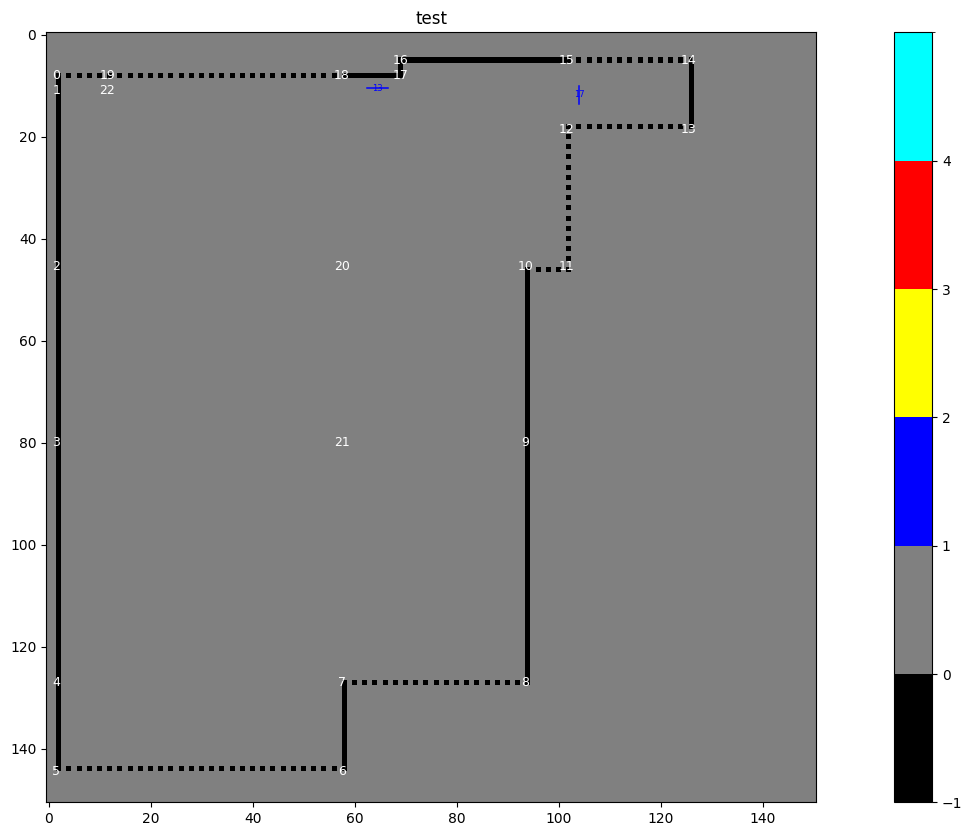

In [99]:
def test_plot_pipes3(pipes_to_plot):
    def plot_pipes(edge_pipes, seg_pts, pipe_color, cmap, pipe_pt, node_pos):
        for (x, y), edge in edge_pipes.items():
            st, ed = seg_pts[x], seg_pts[y]
            def normalized(v):
                return v / np.linalg.norm(v)

            for idx, pipe_id in enumerate(edge.ccw_pipes):
                if pipe_id not in pipes_to_plot:
                    continue
                color = cmap[pipe_color[pipe_id]]
                assert len(pipe_pt[pipe_id]) == 2
                pt0, pt1 = pipe_pt[pipe_id]
                st = node_pos[(pipe_id, pt0)]
                ed = node_pos[(pipe_id, pt1)]
                plt.plot([st[1], ed[1]],
                        [st[0], ed[0]],
                        color=color, linewidth=1.1)
                # 在中点绘制文字 pipe_id
                mid = (st + ed) / 2
                plt.text(mid[1], mid[0], f'{pipe_id}', color='blue', fontsize=6, ha='center', va='center')
    # [pt sets]             
    # print('--- pt sets ---')
    # for k, v in pt_pipe_sets.items():
    #     print(f'{k}:')
    #     print(v.get_sets_di())

    plt.figure(figsize=(20, 10))
    plot_matrix(GLOBAL_MAT, title='test')
    plot_num(SEG_PTS)
    plot_pipes(EDGE_PIPES, SEG_PTS, PIPE_COLOR, CMAP, PIPE_PT, NODE_POS_S1)
    plt.show()

test_plot_pipes3([13, 17])


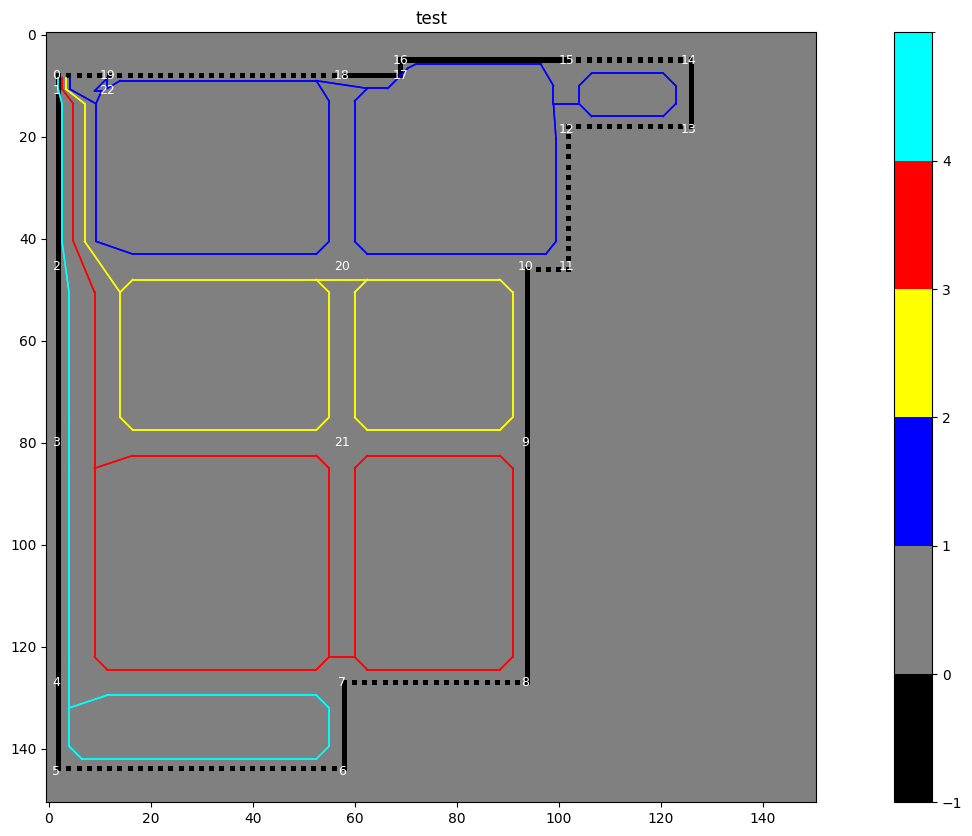

95 96


In [100]:
from plane import same_point
"""
最后搞成无环图即可
"""

def the_other(x, li):
    assert len(li) == 2
    return li[0] if x == li[1] else li[1]

def build_linked_g2(node_set, edge_dict, pt_pipe_sets, edge_info_s1, pipe_pt):
    node_set = copy.deepcopy(node_set)
    edge_dict = copy.deepcopy(edge_dict)
    edge_info_s2 = copy.deepcopy(edge_info_s1)

    for pt_id in pt_pipe_sets.keys():
        for _, disjoint in pt_pipe_sets[pt_id].get_sets_di().items():
            for i in range(1, len(disjoint)):
                assert (disjoint[i], pt_id) in node_set
                u = (disjoint[i], pt_id)
                v = (disjoint[i - 1], pt_id)
                edge_dict[u].append(v)
                edge_dict[v].append(u)

                uv_edge_id = get_g2_edge_id((u, v))
                uo = (disjoint[i], the_other(pt_id, pipe_pt[disjoint[i]]))
                vo = (disjoint[i - 1], the_other(pt_id, pipe_pt[disjoint[i - 1]]))
                u_pipe_edge_id = get_g2_edge_id((uo, u))
                v_pipe_edge_id = get_g2_edge_id((vo, v))

                lw = min(edge_info_s1[u_pipe_edge_id].lw, edge_info_s1[v_pipe_edge_id].lw, 
                         edge_info_s1[v_pipe_edge_id].rw, edge_info_s1[u_pipe_edge_id].rw)
                rw = lw
                edge_info_s2[uv_edge_id] = G0EdgeInfo(rw, lw)


    return node_set, edge_dict, edge_info_s2

NODE_SET_S2, EDGE_DICT_S2, EDGE_INFO_S2 = build_linked_g2(NODE_SET_S1, EDGE_DICT_S1, PT_PIPE_SETS, EDGE_INFO_S1, PIPE_PT)
# print(NODE_SET_S2)
for k, v in EDGE_DICT_S2.items():
    # print(f"{k}: {v}")
    assert k in NODE_SET_S2
    assert all([x in NODE_SET_S2 for x in v])

def test_g2_s2():
    plt.figure(figsize=(20, 10))
    plot_matrix(GLOBAL_MAT, title='test')
    # plot_num(SEG_PTS)
    # plot all edge in EDGE_DICT_S2
    
    for k, v in EDGE_DICT_S2.items():
        for vv in v:
            st = NODE_POS_S1[k]
            ed = NODE_POS_S1[vv]
            plt.plot([st[1], ed[1]],
                    [st[0], ed[0]],
                    color=CMAP[PIPE_COLOR[k[0]]], linewidth=1.1)
    plt.show()

# test_g2_s2()

# 去重. 几乎重合的点合并，边关系也合并
def g2_unique_xy(node_set_s2, edge_dict_s2, node_pos_s2, edge_info_s2, dest_pt):
    node_set_s3: Set[G2Node] = set()
    edge_dict_s3: Dict[G2Node, Set[G2Node]] = dict()
    node_pos_s3: Dict[G2Node, Point] = dict()
    map_s2_s3: Dict[G2Node, G2Node] = dict()
    edge_info_s3: Dict[G2Edge, G0EdgeInfo] = dict()

    not_taken = copy.deepcopy(node_set_s2)
    for u_s2 in node_set_s2:
        if u_s2 not in not_taken:
            continue
        same_li = []
        for v_s2 in not_taken:
            if same_point(node_pos_s2[u_s2], node_pos_s2[v_s2]):
                same_li.append(v_s2) # can be u_s2
        with_dest = [x for x in same_li if x[1] == dest_pt]
        assert len(with_dest) <= 1
        s3 = with_dest[0] if len(with_dest) > 0 else same_li[0]
        for same in same_li:
            not_taken.remove(same)
            map_s2_s3[same] = s3
        node_set_s3.add(s3)
        node_pos_s3[s3] = node_pos_s2[s3]

    # copy edges
    for u_s2 in node_set_s2:
        u_s3 = map_s2_s3[u_s2]
        if u_s3 not in edge_dict_s3:
            edge_dict_s3[u_s3] = set()
        for v_s2 in edge_dict_s2[u_s2]:
            v_s3 = map_s2_s3[v_s2]
            if u_s3 != v_s3 and v_s3 not in edge_dict_s3[u_s3]:
                edge_dict_s3[u_s3].add(v_s3)
                

    for (u_s2, v_s2), info in edge_info_s2.items():
        assert u_s2 < v_s2
        u_s3 = map_s2_s3[u_s2]
        v_s3 = map_s2_s3[v_s2]
        # [NOTE] 这是 first cover，可能有问题
        if (u_s3, v_s3) not in edge_info_s3:
            edge_info_s3[(u_s3, v_s3)] = info

    return node_set_s3, edge_dict_s3, node_pos_s3, edge_info_s3

G2_NODE_SET_S3, G2_EDGE_DICT_S3, G2_NODE_POS_S3, G2_EDGE_INFO_S3 = g2_unique_xy(NODE_SET_S2, EDGE_DICT_S2, NODE_POS_S1, EDGE_INFO_S2, DESTINATION_PT)
    
def test_g2_s3():
    plt.figure(figsize=(20, 10))
    plot_matrix(GLOBAL_MAT, title='test')
    # plot_num(SEG_PTS)
    # plot all edge in EDGE_DICT_S2
    plot_num(SEG_PTS)
    
    for k, v in G2_EDGE_DICT_S3.items():
        for vv in v:
            st = G2_NODE_POS_S3[k]
            ed = G2_NODE_POS_S3[vv]
            plt.plot([st[1], ed[1]],
                    [st[0], ed[0]],
                    color=CMAP[PIPE_COLOR[k[0]]], linewidth=1.1)
    plt.show()

test_g2_s3()
print(len(G2_NODE_SET_S3), len(NODE_SET_S2))

In [101]:
print(PT_PIPE_SETS[1].get_sets_di())

{38: [5, 0, 38], 40: [39, 40], 43: [42, 43], 47: [46, 47]}


2025-01-16 21:52:05.746 | WARNING  | plane:pt_dir_intersect:219 - cross in the inverse direction
2025-01-16 21:52:05.746 | WARNING  | plane:inner_recursive_v2:476 - len(res) = 13


G2_START_NODES: [(47, 0), (38, 0), (43, 0), (40, 0)]
(47, 0)
4
in (47, 0)
    (47, 0) -> (47, 1)
in (47, 1)
    (47, 1) -> (46, 1)
in (46, 1)
    (46, 1) -> (46, 2)
in (46, 2)
    (46, 2) -> (45, 2)
in (45, 2)
    (45, 2) -> (45, 3)
in (45, 3)
    (45, 3) -> (44, 3)
in (44, 3)
    (44, 3) -> (44, 4)
in (44, 4)
    (44, 4) -> (34, 4)
in (34, 4)
    (34, 4) -> (34, 5)
in (34, 5)
    (34, 5) -> (35, 5)
in (35, 5)
    (35, 5) -> (35, 6)
in (35, 6)
    (35, 6) -> (36, 6)
in (36, 6)
    (36, 6) -> (36, 7)
in (36, 7)
    (36, 7) -> (37, 7)
in (37, 7)
    (37, 7) -> (37, 4)
in (37, 4)
   (37, 4) -> (34, 4) is not a tree edge
found cycle: [(34, 4), (34, 5), (35, 5), (35, 6), (36, 6), (36, 7), (37, 7), (37, 4)]
pts (test it): [array([132.,   4.]), array([139.5,   4. ]), array([142. ,   6.5]), array([142. ,  52.5]), array([139.5,  55. ]), array([132.,  55.]), array([129.5,  52.5]), array([129.5,  11.5])]
   (34, 4) -> (37, 4) is not a tree edge


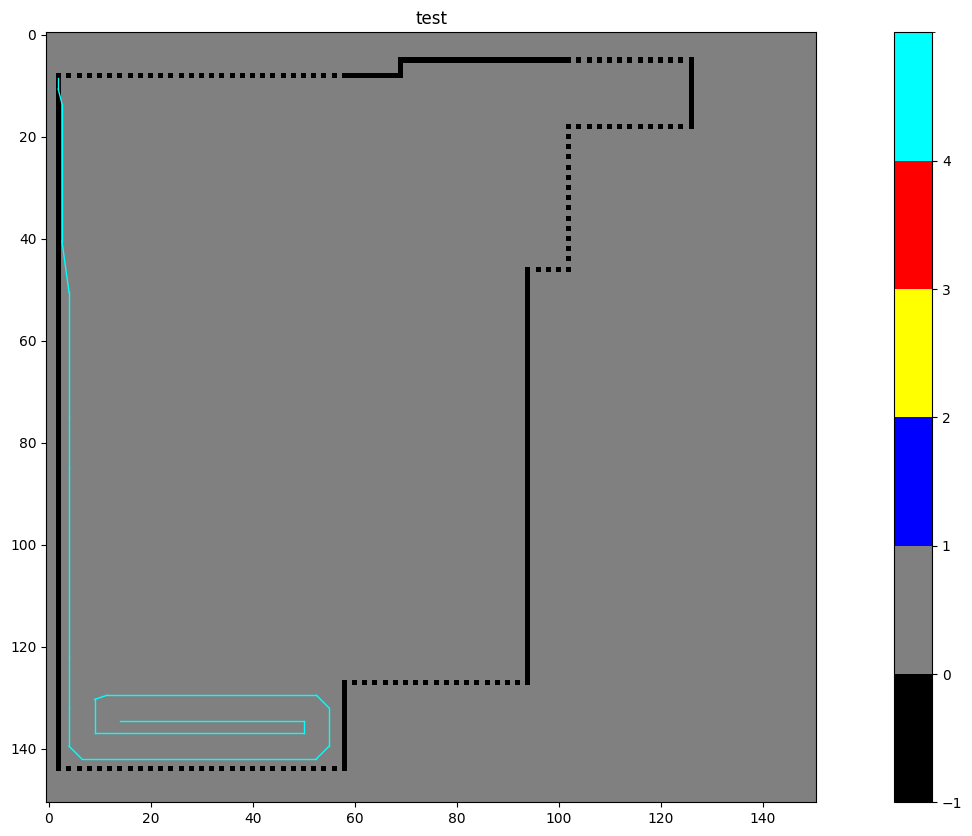

In [102]:
importlib.reload(plane)
from plane import inner_recursive_v2_api
from dataclasses import dataclass
"""
从 0 出发直接找环，若是环则直接圈 v1
"""

G3Node = Tuple[str, Hashable] # ("outer", (pipe_id, pt_id)) | ("inner", ((pipe_id, pt_id), son_idx))
G3Edge = Tuple[G3Node, G3Node]

def g3_node_id_less(e1: G3Node, e2: G3Node):
    # outer 排前面
    if (e1[0] == "inner") != (e2[0] == "inner"):
        return int(e1[0] == "inner") < int(e2[0] == "inner")
    # 同类
    return e1[1] < e2[1]


def get_g3_edge_id(e: G3Edge):
    assert e[0] != e[1]
    if g3_node_id_less(e[0], e[1]):
        return e
    return (e[1], e[0])

def g3_tarjan_for_a_color(start_node, node_set, edge_dict, node_pos, edge_info, w_sug: float):
    """
    参数均为 G2
    """
    g3_node: Set[G3Node] = set()
    # 有向边
    g3_edge: Dict[G3Node, List[G3Node]] = dict() # copy.deepcopy(edge_dict)
    g3_edge_info: Dict[G3Edge, G0EdgeInfo] = dict() # copy.deepcopy(edge_dict)
    g3_node_pos: Dict[G3Node, Point] = dict()
    stack = []

    dfn = dict()
    low = dict()
    cnt = 0

    def tarjan(u, fa):
        nonlocal cnt # nonlocal stack value
        cnt += 1
        dfn[u] = low[u] = cnt
        stack.append(u)

        # [g3]
        g3_node.add(("outer", u))
        g3_node_pos[("outer", u)] = node_pos[u]


        def solve_id(id1, id2):
            # 存储时 rw 方向如何确定？永远都是小 id 指向大 id
            nonlocal w_sug
            # print(f"adding {get_g3_edge_id((id1, id2))}")
            if id1[0] == "outer" and id2[0] == "outer":
                g2_id1 = id1[1]
                g2_id2 = id2[1]
                # 顺序一致
                g3_edge_info[get_g3_edge_id((id1, id2))] = edge_info[get_g2_edge_id((g2_id1, g2_id2))]
                return
            g3_edge_info[get_g3_edge_id((id1, id2))] = G0EdgeInfo(w_sug / 2.0, w_sug / 2.0)

        def solve_g2_cycle(cycle: List[G2Node]):
            rt = cycle[0]
            # 由于保持内盘旋 w_sug 需要，尾部若干点可能被删除
            # [方法1]
            # 原点保持存在，并连接到当前外围最后一点
            # - 为何不投影
            #   - 会交叉
            # - 为何不放宽缺口处宽度要求
            #   - 首尾共线时宽度可能为 0
            # [方法2] [当前方案]
            # - 强制找到某一个起点使得不用删除 outer。可能失败
            def fn():
                no_del_cycle = copy.deepcopy(cycle)
                for _ in range(len(cycle)):
                    pts_xy = [node_pos[x] for x in no_del_cycle]
                    ret = inner_recursive_v2_api(pts_xy, w_sug, dont_delete_outer=True, start_must_be_convex=True)
                    if ret is not None:
                        inner_pts, indices = ret
                        return no_del_cycle, inner_pts, indices
                    no_del_cycle = no_del_cycle[1:] + [no_del_cycle[0]]
                raise ValueError('Can\'t find any circle without outer deletion.')
            # inner_pts, indices = inner_recursive_v2_api(pts_xy, w_sug)
            no_del_cycle, inner_pts, indices = fn()
            print(f'found cycle: {cycle}')
            print(f'pts (test it): {[node_pos[x] for x in no_del_cycle]}')

                

            rt_idx = no_del_cycle.index(rt)
            # [反向加 outer 边]
            for i in range(rt_idx, 0, -1):
                g3_id = ("outer", no_del_cycle[i])
                g3_nxt_id = ("outer", no_del_cycle[i - 1])
                g3_edge[g3_id] = g3_edge.get(g3_id, []) + [g3_nxt_id]
                solve_id(g3_id, g3_nxt_id)
            # [正向加 outer 边]
            for i in range(rt_idx, len(no_del_cycle) - 1):
                g3_id = ("outer", no_del_cycle[i])
                g3_nxt_id = ("outer", no_del_cycle[i + 1])
                g3_edge[g3_id] = g3_edge.get(g3_id, []) + [g3_nxt_id]
                solve_id(g3_id, g3_nxt_id)
            # [制作 inner 点和边]
            last_id = ("outer", no_del_cycle[-1])
            for idx, pt in enumerate(inner_pts[len(no_del_cycle):]):
                g3_id = ("inner", (no_del_cycle[-1], idx))
                g3_node.add(g3_id)
                g3_edge[last_id] = g3_edge.get(last_id, []) + [g3_id]
                g3_node_pos[g3_id] = pt
                solve_id(last_id, g3_id)
                last_id = g3_id

        print(f'in {u}')
        for v in edge_dict[u]:
            if v == fa:
                continue
            if v not in dfn:
                # [树边]
                # g3_edge[u] = g3_edge.get(u, []) + [v]
                print(f'    {u} -> {v}')
                tarjan(v, u)
                low[u] = min(low[u], low[v])
                if low[v] > dfn[u]:
                    assert stack[-1] == v
                    # 非环边
                    g3_uid = ("outer", u)
                    g3_vid = ("outer", v)
                    g3_edge[g3_uid] = g3_edge.get(g3_uid, []) + [g3_vid]
                    solve_id(g3_uid, g3_vid)
                    stack.pop()
                elif low[v] == dfn[u]:
                    # 环首边，退栈求环
                    cycle = []
                    while stack[-1] != u:
                        cycle.append(stack.pop())
                    cycle.append(u) # 不 pop
                    cycle.reverse()
                    solve_g2_cycle(cycle)
            else:
                print(f'   {u} -> {v} is not a tree edge')
                low[u] = min(low[u], dfn[v])

        """
        无向图二元环就是重边
        """
            
    tarjan(start_node, None)
    return g3_node, g3_edge, g3_node_pos, g3_edge_info
               
# check 0
def g2_get_start_nodes(g2_node_set, pipe_color, dest_pt):
    # 同色保留第一个
    color_registered = set()
    res = []
    for node in g2_node_set:
        if node[1] == dest_pt:
            if pipe_color[node[0]] not in color_registered:
                color_registered.add(pipe_color[node[0]])
                res.append(node)
            else:
                logger.error(f'{node}')
                raise ValueError(f'There are more than one start node in the same color {pipe_color[node[0]]}. Note dest_pt must be in a white region.')
    return res

G2_START_NODES = g2_get_start_nodes(G2_NODE_SET_S3, PIPE_COLOR, DESTINATION_PT)

print(f'G2_START_NODES: {G2_START_NODES}')

def test_g3_one_color():
    s = G2_START_NODES[0]
    print(s)
    print(PIPE_COLOR[s[0]])
    n, e, p, i = g3_tarjan_for_a_color(
        s,
        G2_NODE_SET_S3,
        G2_EDGE_DICT_S3,
        G2_NODE_POS_S3,
        G2_EDGE_INFO_S3,
        G0_PIPE_WIDTH
    )
    # [blue]
    # print(i[(("outer", (14, 5)), ("outer", (14, 6)))])
    # print(i[(("outer", (10, 12)), ("outer", (10, 29)))])
    # print(i[(("outer", (9, 16)), ("outer", (9, 21)))])

    # [yellow]

    plt.figure(figsize=(20, 10))
    plot_matrix(GLOBAL_MAT, title='test')
    # plot_num(SEG_PTS)
    def dfs_plot(u):
        for v in e.get(u, []):
            plt.plot([p[u][1], p[v][1]], [p[u][0], p[v][0]], color=CMAP[PIPE_COLOR[s[0]]], linewidth=1)
            dfs_plot(v)

    dfs_plot(("outer", s))
    plt.show()

test_g3_one_color()

2025-01-16 21:52:05.941 | WARNING  | plane:pt_dir_intersect:219 - cross in the inverse direction
2025-01-16 21:52:05.942 | WARNING  | plane:inner_recursive_v2:476 - len(res) = 13


in (47, 0)
    (47, 0) -> (47, 1)
in (47, 1)
    (47, 1) -> (46, 1)
in (46, 1)
    (46, 1) -> (46, 2)
in (46, 2)
    (46, 2) -> (45, 2)
in (45, 2)
    (45, 2) -> (45, 3)
in (45, 3)
    (45, 3) -> (44, 3)
in (44, 3)
    (44, 3) -> (44, 4)
in (44, 4)
    (44, 4) -> (34, 4)
in (34, 4)
    (34, 4) -> (34, 5)
in (34, 5)
    (34, 5) -> (35, 5)
in (35, 5)
    (35, 5) -> (35, 6)
in (35, 6)
    (35, 6) -> (36, 6)
in (36, 6)
    (36, 6) -> (36, 7)
in (36, 7)
    (36, 7) -> (37, 7)
in (37, 7)
    (37, 7) -> (37, 4)
in (37, 4)
   (37, 4) -> (34, 4) is not a tree edge
found cycle: [(34, 4), (34, 5), (35, 5), (35, 6), (36, 6), (36, 7), (37, 7), (37, 4)]
pts (test it): [array([132.,   4.]), array([139.5,   4. ]), array([142. ,   6.5]), array([142. ,  52.5]), array([139.5,  55. ]), array([132.,  55.]), array([129.5,  52.5]), array([129.5,  11.5])]
   (34, 4) -> (37, 4) is not a tree edge


2025-01-16 21:52:05.949 | WARNING  | plane:pt_dir_intersect:219 - cross in the inverse direction
2025-01-16 21:52:05.949 | INFO     | plane:inner_recursive_v2:400 - Can't satisfy dont_delete_outer
2025-01-16 21:52:05.950 | WARNING  | plane:pt_dir_intersect:219 - cross in the inverse direction
2025-01-16 21:52:05.950 | INFO     | plane:inner_recursive_v2:400 - Can't satisfy dont_delete_outer
2025-01-16 21:52:05.953 | WARNING  | plane:pt_dir_intersect:219 - cross in the inverse direction
2025-01-16 21:52:05.953 | WARNING  | plane:inner_recursive_v2:476 - len(res) = 11
2025-01-16 21:52:05.955 | WARNING  | plane:pt_dir_intersect:219 - cross in the inverse direction
2025-01-16 21:52:05.956 | INFO     | plane:inner_recursive_v2:400 - Can't satisfy dont_delete_outer
2025-01-16 21:52:05.957 | INFO     | plane:inner_recursive_v2:376 - Can't satisfy start_must_be_convex
2025-01-16 21:52:05.957 | WARNING  | plane:pt_dir_intersect:219 - cross in the inverse direction
2025-01-16 21:52:05.958 | INFO

in (38, 0)
    (38, 0) -> (38, 1)
in (38, 1)
    (38, 1) -> (0, 1)
in (0, 1)
    (0, 1) -> (0, 2)
in (0, 2)
    (0, 2) -> (1, 2)
in (1, 2)
    (1, 2) -> (1, 20)
in (1, 20)
    (1, 20) -> (2, 20)
in (2, 20)
    (2, 20) -> (2, 18)
in (2, 18)
    (2, 18) -> (3, 18)
in (3, 18)
    (3, 18) -> (3, 19)
in (3, 19)
    (3, 19) -> (4, 19)
in (4, 19)
    (4, 19) -> (4, 22)
in (4, 22)
    (4, 22) -> (5, 22)
in (5, 22)
    (5, 22) -> (5, 1)
in (5, 1)
   (5, 1) -> (0, 1) is not a tree edge
    (3, 18) -> (13, 18)
in (13, 18)
    (13, 18) -> (13, 17)
in (13, 17)
    (13, 17) -> (12, 17)
in (12, 17)
    (12, 17) -> (11, 16)
in (11, 16)
    (11, 16) -> (11, 15)
in (11, 15)
    (11, 15) -> (10, 15)
in (10, 15)
    (10, 15) -> (10, 12)
in (10, 12)
    (10, 12) -> (17, 12)
in (17, 12)
    (17, 12) -> (14, 12)
in (14, 12)
    (14, 12) -> (14, 13)
in (14, 13)
    (14, 13) -> (15, 13)
in (15, 13)
    (15, 13) -> (15, 14)
in (15, 14)
    (15, 14) -> (16, 14)
in (16, 14)
    (16, 14) -> (16, 15)
in (16, 15)
  

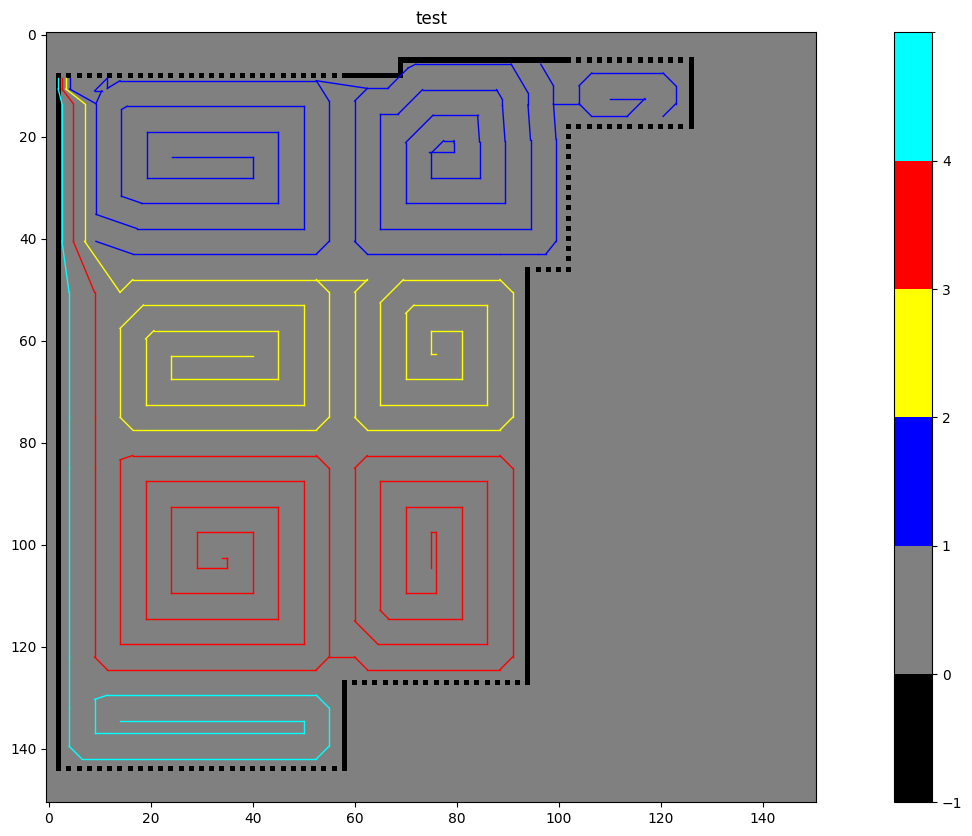

In [103]:
def test_g3_all_color():
    plt.figure(figsize=(20, 10))
    plot_matrix(GLOBAL_MAT, title='test')
    for s in G2_START_NODES:
        n, e, p, i = g3_tarjan_for_a_color(
            s,
            G2_NODE_SET_S3,
            G2_EDGE_DICT_S3,
            G2_NODE_POS_S3,
            G2_EDGE_INFO_S3,
            G0_PIPE_WIDTH
        )

        # plot_num(SEG_PTS)
        def dfs_plot(u):
            for v in e.get(u, []):
                plt.plot([p[u][1], p[v][1]], [p[u][0], p[v][0]], color=CMAP[PIPE_COLOR[s[0]]], linewidth=1)
                dfs_plot(v)

        dfs_plot(("outer", s))
    plt.show()

test_g3_all_color()

2025-01-16 21:52:12.309 | WARNING  | plane:pt_dir_intersect:219 - cross in the inverse direction
2025-01-16 21:52:12.310 | WARNING  | plane:inner_recursive_v2:476 - len(res) = 13
2025-01-16 21:52:12.312 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.312 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.313 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.314 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.315 | WARNING  | plane:pt_dir_intersect:219 - cross in the inverse direction
2025-01-16 21:52:12.316 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.316 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.317 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.317 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.318 | WARNING  | plane:pt_dir_intersect:216 - parallel


in (47, 0)
    (47, 0) -> (47, 1)
in (47, 1)
    (47, 1) -> (46, 1)
in (46, 1)
    (46, 1) -> (46, 2)
in (46, 2)
    (46, 2) -> (45, 2)
in (45, 2)
    (45, 2) -> (45, 3)
in (45, 3)
    (45, 3) -> (44, 3)
in (44, 3)
    (44, 3) -> (44, 4)
in (44, 4)
    (44, 4) -> (34, 4)
in (34, 4)
    (34, 4) -> (34, 5)
in (34, 5)
    (34, 5) -> (35, 5)
in (35, 5)
    (35, 5) -> (35, 6)
in (35, 6)
    (35, 6) -> (36, 6)
in (36, 6)
    (36, 6) -> (36, 7)
in (36, 7)
    (36, 7) -> (37, 7)
in (37, 7)
    (37, 7) -> (37, 4)
in (37, 4)
   (37, 4) -> (34, 4) is not a tree edge
found cycle: [(34, 4), (34, 5), (35, 5), (35, 6), (36, 6), (36, 7), (37, 7), (37, 4)]
pts (test it): [array([132.,   4.]), array([139.5,   4. ]), array([142. ,   6.5]), array([142. ,  52.5]), array([139.5,  55. ]), array([132.,  55.]), array([129.5,  52.5]), array([129.5,  11.5])]
   (34, 4) -> (37, 4) is not a tree edge


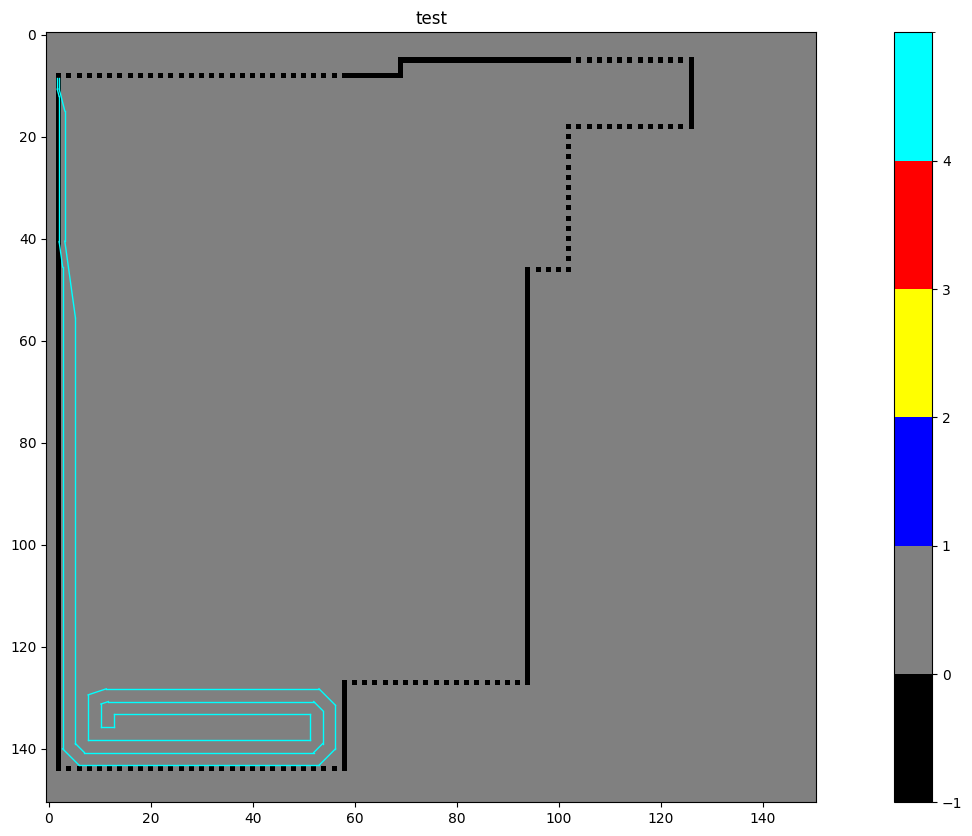

2025-01-16 21:52:12.459 | WARNING  | plane:pt_dir_intersect:219 - cross in the inverse direction
2025-01-16 21:52:12.460 | WARNING  | plane:inner_recursive_v2:476 - len(res) = 13
2025-01-16 21:52:12.462 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.462 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.463 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.463 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.465 | WARNING  | plane:pt_dir_intersect:219 - cross in the inverse direction
2025-01-16 21:52:12.465 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.466 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.467 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.468 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.468 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.474 | WARNING  | plane:pt_dir

in (47, 0)
    (47, 0) -> (47, 1)
in (47, 1)
    (47, 1) -> (46, 1)
in (46, 1)
    (46, 1) -> (46, 2)
in (46, 2)
    (46, 2) -> (45, 2)
in (45, 2)
    (45, 2) -> (45, 3)
in (45, 3)
    (45, 3) -> (44, 3)
in (44, 3)
    (44, 3) -> (44, 4)
in (44, 4)
    (44, 4) -> (34, 4)
in (34, 4)
    (34, 4) -> (34, 5)
in (34, 5)
    (34, 5) -> (35, 5)
in (35, 5)
    (35, 5) -> (35, 6)
in (35, 6)
    (35, 6) -> (36, 6)
in (36, 6)
    (36, 6) -> (36, 7)
in (36, 7)
    (36, 7) -> (37, 7)
in (37, 7)
    (37, 7) -> (37, 4)
in (37, 4)
   (37, 4) -> (34, 4) is not a tree edge
found cycle: [(34, 4), (34, 5), (35, 5), (35, 6), (36, 6), (36, 7), (37, 7), (37, 4)]
pts (test it): [array([132.,   4.]), array([139.5,   4. ]), array([142. ,   6.5]), array([142. ,  52.5]), array([139.5,  55. ]), array([132.,  55.]), array([129.5,  52.5]), array([129.5,  11.5])]
   (34, 4) -> (37, 4) is not a tree edge
in (38, 0)
    (38, 0) -> (38, 1)
in (38, 1)
    (38, 1) -> (0, 1)
in (0, 1)
    (0, 1) -> (0, 2)
in (0, 2)
    (0,

2025-01-16 21:52:12.510 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.512 | WARNING  | plane:pt_dir_intersect:219 - cross in the inverse direction
2025-01-16 21:52:12.514 | WARNING  | plane:pt_dir_intersect:219 - cross in the inverse direction
2025-01-16 21:52:12.515 | WARNING  | plane:pt_dir_intersect:219 - cross in the inverse direction
2025-01-16 21:52:12.515 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.545 | WARNING  | plane:pt_dir_intersect:219 - cross in the inverse direction
2025-01-16 21:52:12.546 | WARNING  | plane:inner_recursive_v2:476 - len(res) = 23
2025-01-16 21:52:12.549 | WARNING  | plane:pt_dir_intersect:219 - cross in the inverse direction
2025-01-16 21:52:12.550 | WARNING  | plane:inner_recursive_v2:476 - len(res) = 25
2025-01-16 21:52:12.551 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.552 | WARNING  | plane:pt_dir_intersect:216 - parallel
2025-01-16 21:52:12.554 | WARNING  | plane:pt_dir_i

in (43, 0)
    (43, 0) -> (43, 1)
in (43, 1)
    (43, 1) -> (42, 1)
in (42, 1)
    (42, 1) -> (42, 2)
in (42, 2)
    (42, 2) -> (41, 2)
in (41, 2)
    (41, 2) -> (41, 3)
in (41, 3)
    (41, 3) -> (26, 3)
in (26, 3)
    (26, 3) -> (26, 4)
in (26, 4)
    (26, 4) -> (27, 4)
in (27, 4)
    (27, 4) -> (27, 7)
in (27, 7)
    (27, 7) -> (28, 7)
in (28, 7)
    (28, 7) -> (30, 7)
in (30, 7)
    (30, 7) -> (31, 7)
in (31, 7)
    (31, 7) -> (31, 8)
in (31, 8)
    (31, 8) -> (32, 8)
in (32, 8)
    (32, 8) -> (32, 9)
in (32, 9)
    (32, 9) -> (33, 9)
in (33, 9)
    (33, 9) -> (33, 21)
in (33, 21)
    (33, 21) -> (30, 21)
in (30, 21)
   (30, 21) -> (30, 7) is not a tree edge
found cycle: [(30, 7), (31, 7), (31, 8), (32, 8), (32, 9), (33, 9), (33, 21), (30, 21)]
pts (test it): [array([122.,  60.]), array([124.5,  62.5]), array([124.5,  88.5]), array([122.,  91.]), array([85., 91.]), array([82.5, 88.5]), array([82.5, 62.5]), array([85., 60.])]
   (30, 7) -> (30, 21) is not a tree edge
    (28, 7) -> (

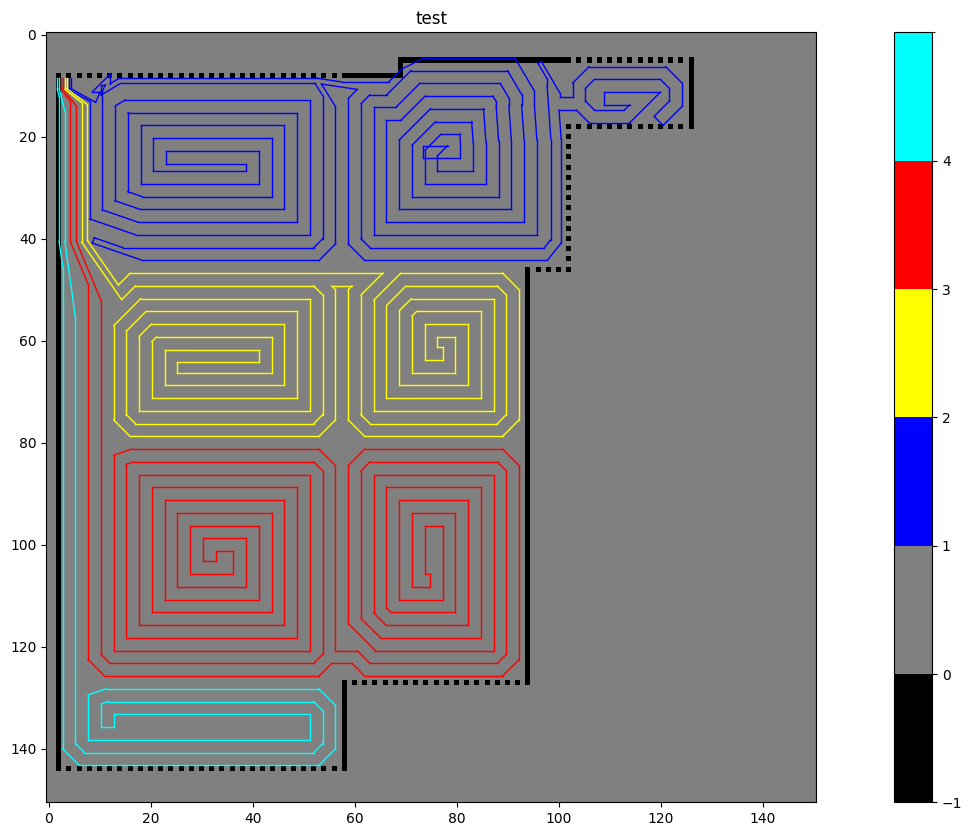

In [105]:
# [M1]
importlib.reload(plane)
from plane import dir_left, dir_right, Vec, line_cross, line_at_dir, eq, same_line, pt_dir_intersect
from copy import deepcopy
def gen_one_color_m1(
    start_g3_node,
    dest_pt,
    g3_edge_dict,
    g3_node_pos,
    g3_edge_info,
):
    def dfs(u, dir_to_u, rw_to_u, lw_to_u, res_ref: List[Tuple[Point, Vec]]):
        """
        u is a g3 node
        """
        nonlocal dest_pt
        sons = deepcopy(g3_edge_dict.get(u, []))
        u_is_root = (u[0] == "outer" and u[1][1] == dest_pt)
        if u_is_root:
            assert len(sons) == 1
        else:
            assert dir_to_u is not None

        def ref_append(pt_side, dir):
            while len(res_ref) > 0:
                # [v2] [BUG] 目前之前步骤有可能给出平行不共线的，需要解决
                cross = pt_dir_intersect((res_ref[-1][0], res_ref[-1][1]), (pt_side, dir))
                if cross is None:
                    res_ref.pop()
                    continue

                res_ref.append((cross, dir))
                return
            # must be len == 0
            res_ref.append((pt_side, dir))
                
        u_pos = g3_node_pos[u]
        # [儿子极角排序]
        def cmp(v):
            v_pos = g3_node_pos[v]
            dir = normalized(v_pos - u_pos)
            x, y = dir @ dir_to_u, dir @ dir_left(dir_to_u)
            return np.arctan2(y, x)
        if len(sons) >= 2:
            sons.sort(key=cmp)

        for v in sons:
            v_pos = g3_node_pos[v]
            dir_uv = normalized(v_pos - u_pos)
            right = dir_right(dir_uv)

            min_max_id = get_g3_edge_id((u, v))
            min_max_rw_lw = g3_edge_info[min_max_id].rw, g3_edge_info[min_max_id].lw
            rw, lw = min_max_rw_lw if g3_node_id_less(u, v) else min_max_rw_lw[::-1]

            pt_right_side = u_pos + right * rw / 2.0
            ref_append(pt_right_side, dir_uv)

            dfs(v, dir_uv, rw, lw, res_ref)

            # [?] u or v?
            pt_left_side = v_pos - right * lw / 2.0
            ref_append(pt_left_side, -dir_uv)

        if len(sons) == 0:
            left = dir_left(dir_to_u)
            pt_front = u_pos + dir_to_u * min(rw_to_u, lw_to_u) / 2.0
            ref_append(pt_front, left)
        # 如果是根，还需要多加一条边，相交生成出水处
        if u_is_root:
            dir_to_only_son = normalized(g3_node_pos[sons[0]] - u_pos)
            ref_append(u_pos, dir_right(dir_to_only_son))

    res_ref = []
    dfs(start_g3_node, None, None, None, res_ref)
    return res_ref

            
def test_gen_one_color_m1():

    one_color = 0
    s = G2_START_NODES[one_color]
    n, e, p, i = g3_tarjan_for_a_color(
        s,
        G2_NODE_SET_S3,
        G2_EDGE_DICT_S3,
        G2_NODE_POS_S3,
        G2_EDGE_INFO_S3,
        G0_PIPE_WIDTH
    )
    
    res = gen_one_color_m1(
        ("outer", s),
        DESTINATION_PT,
        e,
        p,
        i
    )
    plt.figure(figsize=(20, 10))
    plot_matrix(GLOBAL_MAT, title='test')
    pts = [x[0] for x in res]
    # plot them
    for i in range(len(pts) - 1):
        plt.plot([pts[i][1], pts[i + 1][1]], [pts[i][0], pts[i + 1][0]], color=CMAP[PIPE_COLOR[s[0]]], linewidth=1)
    plt.show()

test_gen_one_color_m1()

def test_gen_all_color_m1():
    plt.figure(figsize=(20, 10))
    plot_matrix(GLOBAL_MAT, title='test')
    for one_color in range(len(G2_START_NODES)):
        s = G2_START_NODES[one_color]
        n, e, p, i = g3_tarjan_for_a_color(
            s,
            G2_NODE_SET_S3,
            G2_EDGE_DICT_S3,
            G2_NODE_POS_S3,
            G2_EDGE_INFO_S3,
            G0_PIPE_WIDTH
        )
        
        res = gen_one_color_m1(
            ("outer", s),
            DESTINATION_PT,
            e,
            p,
            i
        )
        pts = [x[0] for x in res]
        # plot them
        for i in range(len(pts) - 1):
            plt.plot([pts[i][1], pts[i + 1][1]], [pts[i][0], pts[i + 1][0]], color=CMAP[PIPE_COLOR[s[0]]], linewidth=1)
    plt.show()
        
test_gen_all_color_m1()

In [18]:
"""
ok
"""


'\nok\n'